# Исследование объявлений о продаже квартир

В нашем распоряжении оказались данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

**Цель исследования:** Найти и оценить параметры, влияющие на рыночную стоимость недвижимости. Это позволит создать систему отслеживания объявлений, которая будет улавлить появление аномалий и артефактов в данных, как случайных, так и внесённых предумышленно с целью исказить статистику.

**Ход работы:**
- Изучить датафрейм и исправить ошибки и недочёты в данных, где это возможно;
- Добавить столбцы с расчётом дополнительных характеристик объектов недвижимости, которые помогут выполнить более точный анализ;
- По очищенным данным и при помощи новых столбцов провести анализ различных параметров недвижимости (общая и жилая площадь, площадь кухни и пр.).

## 1 Откроем файл с данными и изучим общую информацию

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   

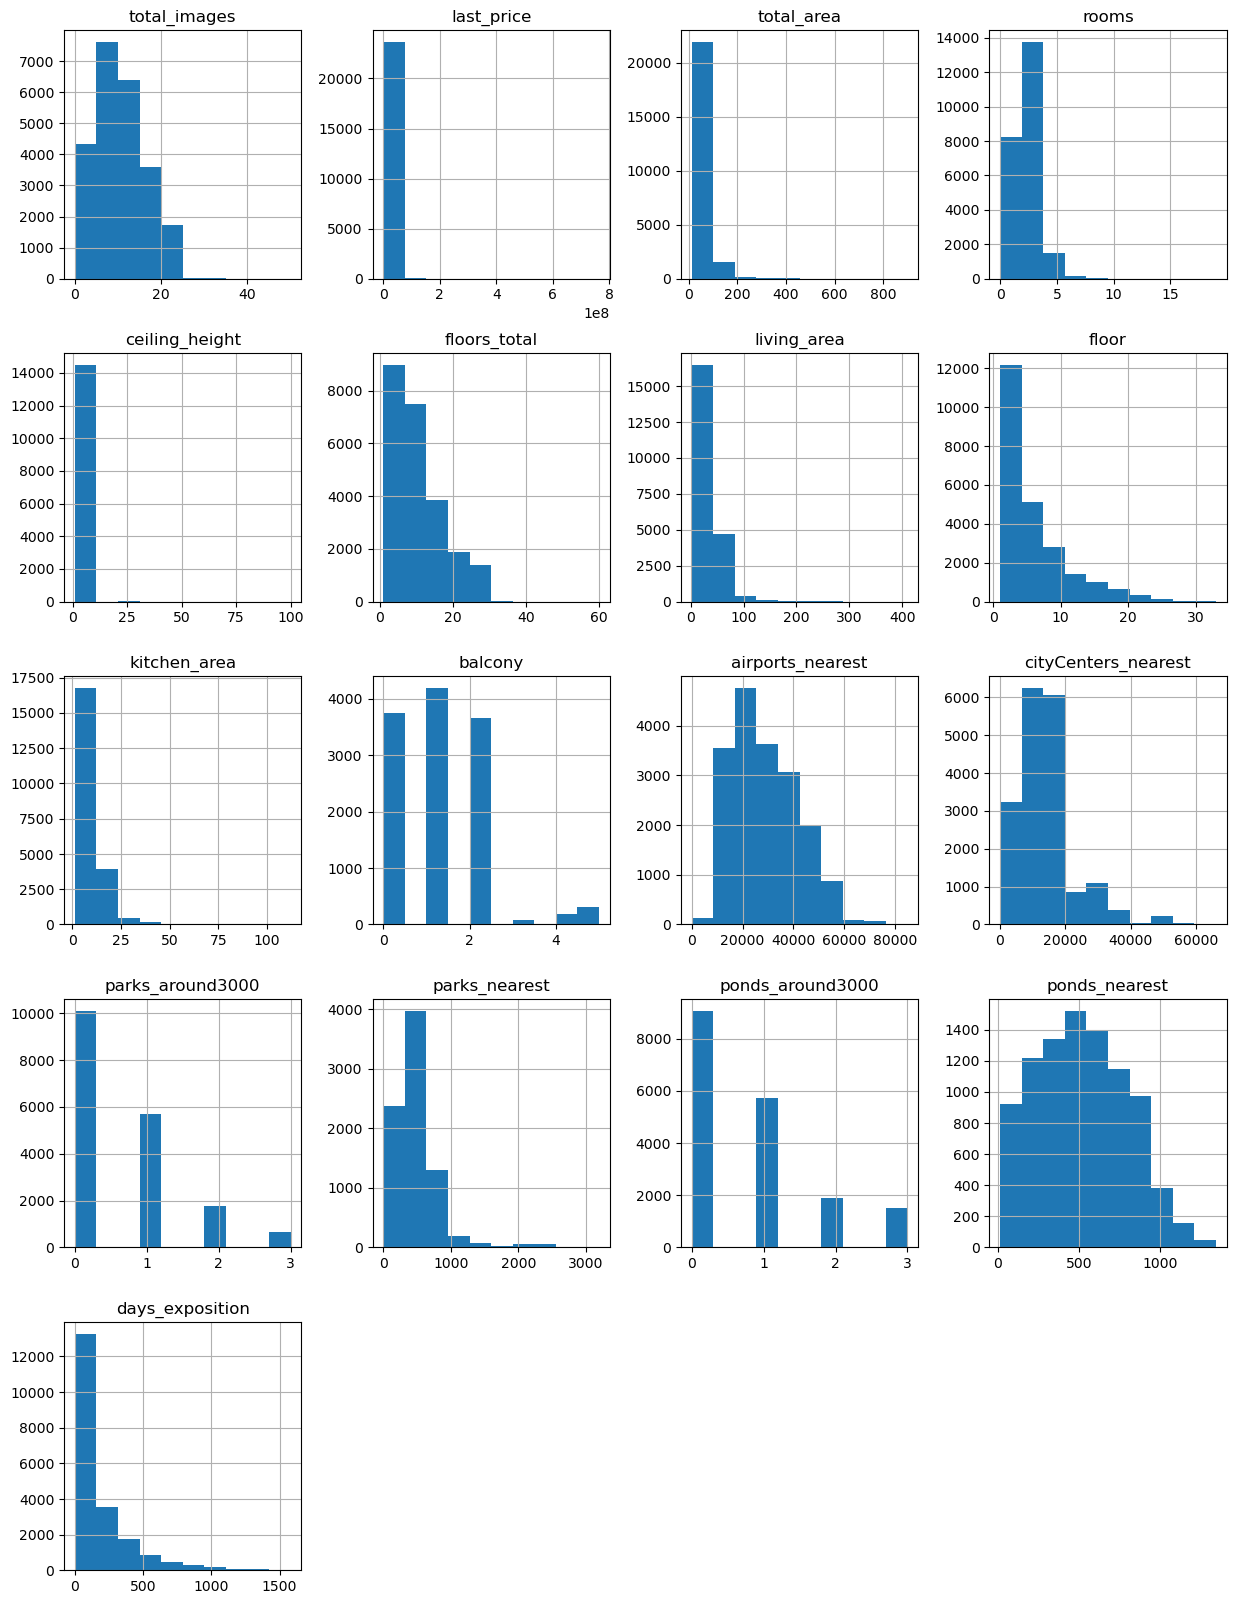

In [59]:
# Импортируем pandas и matplotlib:
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем информацию в датафрейм data. При команде print(data.head()) обнаруживается, что данные склеились из-за разделителей
# \t. Чтобы избавиться от этой проблемы, добавим аргумент функции read_csv параметр sep:
data = pd.read_csv(r'C:\project\real_estate_data.csv', sep='\t')

# Проверяем, что теперь всё ок:
print(data.head(10))

# Построим гистограмму для всех столбцов:
data.hist(figsize=(15, 20))

plt.show()

## 2 Предобработка данных

### 2.1 Проверим наличие пропусков в столбцах:

In [60]:
# Вызовем функцию isna(), которая обнаружит пропущенные данные. А также просуммируем все найденные пропуски:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


**В таблице содержится довольно много пропусков:**

1. `ceiling_height` - высота потолков. Относится к параметрам, которые должен указывать пользователь. На практике далеко не все её указывают, что может приводить к пропускам.

2. `floors_total` - количество этажей. Имеем небольшое кол-во пропусков, которое не повлияет на общий вывод.

3. `living_area, kitchen_area` - жилая площадь и площадь кухни. Довольное большое количество пропусков в обоих столбцах. Данные могли потеряться по разным причинам: ошибки при сохранении или же пользователь просто не посчитал нужным указывать жилую площадь и площадь кухни, указав общую.

4. `is_apartment` - апатаменты. Это относительно новое слово в недвижимости. Таких предложений на рынке недвижимости по крайней мере пока, немного. Пользователь мог проигнорировать заполнение, решив, что и так очевидно, что это квартира.

5. `balcony` - балконы. Их может и не быть в квартире, поэтому их не указали.

6. `locality_name` - локация. Небольшое количество пропусков. Заполнять нет смысла - посчитать "медианное" или "среднее" место жительства невозможно + пропусков столько, что они не повлияют на конечный результат.

7. `airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000` - близость к аэропорту, центру города, паркам и прудам в районе 3 км. Имеют примерно одинаковое количество пропусков. Это картографические данные, которые, скорее всего, потерялись из-за сбоя в записи - на это указывает то, что во всех этих столбцах число потерь примерно одинаково: 5542, 5518, 5518, 5519.

8. `parks_nearest, ponds_nearest` - ближайшие парки и пруды. Вероятна та же причина потери, что и в пункте 7, только утраты примерно в 3 раза выше.

9. `days_exposition` - день и месяц публикации объявления. Потеря значительного количества данных. Вероятно, связана со сбоями в записи данных, так как это число по идее не должно устанавливаться вручную, а должно автоматически записываться при снятии объявления за неактуальностью.

### 2.2 Обработаем пропущенные значения, где это возможно.

**Для начала посмотрим на уникальные значения столбца `ceiling_height`**:

In [61]:
# Вызовем функцию unique, которая вернёт нам все уникальные значения столбца ceiling_height:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

В данных по высоте потолков (ceiling_height) много аномальных значений. По СанПину высота потолка должна быть не ниже 2.5. В реальности встречается разное. Тем не менее:

1. Вряд ли существуют квартиры, где потолок ниже хотя бы 2.3 (высота в некоторых хрущевках);
2. Потолок выше 4.5 метров.

Очевидны ошибки в данных, которые, вероятнее всего, произошли во время записи - например, могли случайно записать высоту потолков в дециметрах, а не в метрах или поставить не там точку в значениях типа "32.", в то время, как точка должна была оказаться между этими двумя цифрами. Наконец, вероятны опечатки или сбои в записи - значения потолка типа "1." или "14" сложно объяснить логически.

**Избавимся от аномальных значений с проставленной не там запятой:**

In [62]:
# Выполним замену значения по условию через loc:
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10, 'ceiling_height'] / 10
data['ceiling_height'].unique()

array([ 2.7 ,   nan,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  2.65,  3.2 ,  2.61,  3.25,  3.45,
        2.77,  2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,
        2.47,  2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,
        2.51,  2.78,  2.76,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,
        2.59,  2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,
        3.55,  3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.3 ,
        5.  ,  2.79,  2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,
        4.7 ,  2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,
        2.3 ,  3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,
        3.95,  3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,
        3.24,  4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,  3.07,  3.37,
        3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,
        2.68,  3.22,  3.27,  4.1 ,  2.93,  3.46,  3.47,  3.33,  3.63,
        3.32,  1.2 ,

Далее очистим в `ceiling_height` данные от неккоректных значений: все величины приведем к примерно одним и тем же значениям. После чего вычислим среднюю медиану примерно похожих квартир и заполним ею пропуски. Чтобы вычислить медиану, нам нужен другой столбец данных, влияющий на высоту потолков. Высота потолков обычно связана с премиальностью квартиры. Премиальность, как правило, определяется общей площадью - чем она больше, тем элитнее и дороже жильё:

In [63]:
# Для слишком высоких потолков установим предел в 4,5 м, а для слишком низких в 2,3:
data.loc[data['ceiling_height'] > 4.5, 'ceiling_height'] = 4.5
data.loc[data['ceiling_height'] < 2.3, 'ceiling_height'] = 2.3
# группируем данные и вычисляем медиану при помощи функции transform:
ceiling_median = data.groupby('total_area')['ceiling_height'].transform('median')
# заполняем полученной медианой пропуски в датафрейме:
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_median, inplace=False)

**Обработаем столбец `living_area`**

В нем пропущено 8% данных - значимая для анализа величина.
Явно аномальных значений в этом столбце нет - скорее всего, указав общую площадь квартиры, люди просто не посчитали нужным заполнять жилую площадь.
Как правило, жилая площадь сильно зависит от общей площади. От неё и будем отталкиваться при вычислении медианы:

In [64]:
# группируем данные при помощи groupby и вычисляем медиану при помощи функции transform:
living_median = data.groupby('total_area')['living_area'].transform('median')
# заполняем полученной медианой пропуски в датафрейме:
data['living_area'] = data['living_area'].fillna(living_median)

**Изучим и обработаем столбец `kitchen_area`**

В нем тоже достаточно много пропусков - 2278 (9.6%). Просто удалить их нельзя, чтобы не исказить конечный результат. Как и в случае с жилой площадью, явных аномальных значений в этом столбце нет - скорее всего, указав общую площадь квартиры, люди просто не посчитали нужным указать площадь кухни.

На площадь кухни, как и на жилую площадь, как правило, сильнее всего влияет общая площадь квартиры. Используя её, снова посчитаем медиану, которая заполнит пропуски:

In [65]:
# группируем данные при помощи groupby и вычисляем медиану при помощи функции transform:
kitchen_median = data.groupby('total_area')['kitchen_area'].transform('median')
# заполняем полученной медианой пропуски в датафрейме:
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_median)

**Изучим и обработаем столбец `balcony`**

В нём много пропусков. Но в отличии от остальных показателей, они здесь могут означать, что балкона в квартире и нет. Логичным будет заполнить его нулевым значением:

In [66]:
# заполняем пропуски в датафрейме нулями:
data['balcony'] = data['balcony'].fillna(0)

**Изучим и обработаем столбец `is_apartment`**

В столбце  пропуски в 20924 значениях из 23699 возможных. Апартаменты довольно редкое жильё в наших реалиях. Логичным будет предположить, что раз тип не указан, значит речь не об апартаментах. Заполним пропуски значениями False:

In [67]:
# заполняем пропуски в датафрейме False:
data['is_apartment'] = data['is_apartment'].fillna(False)

**Пропуски в картографических данных**

Их заполнить достоверными значениями будет сложно. Удалять тоже нежелательно - пропадет значительное количество других интересных нам значений. А именно потеряется 23% датафрейма. Это почти вся информация о недвижимости в Лен. области - это видно, если попытаться очистить от NaN хоть один столбец из `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `ponds_around3000`, а потом проверить `locality_name` на уникальные значения.

Поэтому всё, кроме столбца `cityCenters_nearest`, оставим как есть. В столбце `cityCenters_nearest` пропущенные значения заполним нереалистичным значением, чтобы NaN не мешал использовать столбец в вычислениях (нереалистичное значение в расчетах будем отбрасывать):

In [68]:
# заполняем пропуски в датафрейме нулями:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(999999)

**Изучим и обработаем столбец `days_exposition`**

Не обрабатывать его нежелательно - потеряно слишком много данных. Логичным будет предположить, что скорость продажи зависит от цены и заполнить пропуски медианными значениями предложений примерно одинакового ценового дипазона:

In [69]:
# группируем данные при помощи groupby и вычисляем медиану при помощи функции transform:
days_exposition_median = data.groupby('last_price')['days_exposition'].transform('median')
# заполняем полученной медианой пропуски в датафрейме:
data['days_exposition'] = data['days_exposition'].fillna(days_exposition_median)

Проанализируем изменения после обработки пропусков. Посмотрим сколько их теперь в таблице:

In [70]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            627
floors_total               86
living_area               143
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              205
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest         0
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition           307
dtype: int64


**Видим, что количество пропусков сократилось, если не до нуля, то значительно:**

- Если раньше в столбце `ceiling_height` отсутствовало 38,8% значений (9195), то сейчас отсутствует 2,65% (627). Это не идеальный результат, но значительно лучше того, что было. Пропуск в 2,65% уже можно игнорировать, так как он вряд ли серьезно исказит картину.

- Пропуски в столбце `living_area` есть, но их количество сильно сократилось. Теперь в нем отсутствует всего 0,6% данных (143 значения) по сравнению с предыдущими 8% и 1903 значениями соответственно.

- Сократились пропуски и в столбце `kitchen_area`. Они достигли приемлемого значения: стало 205 вместо 2278.

- Пропущенные значения в `is_apartment`, `cityCenters_nearest` и `balcon`y исчезли после заполнения "False", 0 и 999999.

- Если раньше в столбце `days_exposition` было 3181 пропусков, то сейчас их количество сократилось в 10 раз - пропущено только 307 значений.

### 2.3 Изменение типа данных

**Вызовем метод `info` ещё раз, чтобы оценить какие типы данных проставлены в столбцах и есть ли среди них некорректные:**

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23072 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23556 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23494 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Видим, что в некоторых столбцах использует тип данных, который лучше сменить, так как он может показывать нереалистичные значения или привести к ошибкам в вычислениях.

- Однозначно неправильно указан тип данных в столбцах `first_day_exposition` - он должен быть заменен с object на тип datetime, чтобы с ним можно было проводить расчёты.
- Также стоит заменить тип данных в столбце `floors_total` на целочисленный. Вещественный тип данных для него некорректен, так как вряд ли существует этаж, для записи которого требуются дроби. То же самое можно сказать и про столбец `balcony` - вряд ли существует 1,5 балкона или 2,8.
- Для столбца `last_price` лучше заменить значения на целочисленные для облегчения расчетов графиков.

In [72]:
# Чтобы преобразовать float64 в int64, удалим пропуски в столбце floors_total. Их немного - на точность анализа не повлияет:
data.dropna(subset=['floors_total'], inplace=True)
# Преобразуем тип данных в целочисленный:
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['last_price'] = data['last_price'].astype('int')
# Меняем некорректный тип данных на datetime в столбцах first_day_exposition и days_exposition:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
# Убеждаемся, что смена типа данных произошла: при помощи info:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  int32         
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23017 non-null  float64       
 6   floors_total          23613 non-null  int32         
 7   living_area           23480 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          23428 non-null  float64       
 13  balcony         

### 2.4 Устранение дубликатов

**Проверим датафрейм на наличие явных дубликатов:**

In [73]:
print(data.duplicated().sum())

0


Явных дубликатов в датафрейме нет.

**Проверим уникальные значения в столбце `locality_name`, чтобы выявить неявные дубликаты:**

In [74]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Видим, что явных дубликатов, опять же, нет. Ошибок тоже. Зато присутствует большое количество неявных дубликатов. Это:
1. Разное написание слова "*посёлок*": в одном варианте "*посЕлок*", а в другом "*посЁлок*".

2. Топонимы "*городской посёлок*" и "*посёлок городского типа*" в некоторых местах дублируются себя. Например, в списке есть "*городской поселок Назия*" и "*посёлок городского типа Назия*" - один и тот же населённый пункт с разными (но тождественными по значению) приставками;

3. '*Поселок Мурино*' и '*посёлок Мурино*' считаются за разные населенные пункты. При этом у Мурино уже давно статус города. Та же история с Кудрово: есть "*Кудрово*" и "*деревня Кудрово*". У посёлка Рябово вообще три разных статуса.

Приведём неявные дубликаты к единому значению: все поселки превратим в пос**ё**лки, "*городской посёлок*" заменим на более распространённое "*посёлок городского типа*", избавимся от дублей у Мурино, Рябово и Кудрово:

In [75]:
# Приводим неоднозначные значения к единому написанию через метод replace. Активируем параметр regex=True, чтобы замена 
# сработала:
data['locality_name'] = (
    data['locality_name']
    .replace('поселок', 'посёлок', regex=True)
    .replace('посёлок Рябово', 'посёлок городского типа Рябово', regex=True)
    .replace('посёлок Мурино', 'Мурино', regex=True)
    .replace('деревня Кудрово', 'Кудрово', regex=True)
    .replace('городской посёлок', 'посёлок городского типа', regex=True)
)
# Проверим, что получилось:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары',
       'посёлок городского типа Янино-1', 'посёлок Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'посёлок городского типа Красный Бор',
       'Гатчина', 'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'посёлок Молодцово',
       'посёлок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'посёлок Торковичи', 'посёлок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы

Неявные дубликаты устранены.

**В этом блоке была проведена следующая работа:**
- Найдены и заменены аномальные и пропущенные значения;
- Установлены и устранены неявные дубликаты датафрейма;
- Тип некоторых столбцов был изменён, на более подходящий как для отображения значений, которые они содержат, так и для облегчения расчетов.
Теперь данные достаточно обработаны, чтобы с ними можно было работать дальше.

### 3 Добавим в таблицу новые столбцы

#### 3.1 Добавим в таблицу новый столбец, отражающий цену за кв.м. недвижимости: 

In [76]:
# создаём столбец one_sq_m_price, в который поместим стоимость жилья, поделенную на общую площадь. Установим тип данных int для 
# удобства расчетов:
data['one_sq_m_price'] = (data['last_price'] / data['total_area']).astype('int')

#### 3.2 Добавим столбцы, в которых будут отражены день публикации объявления (0 - понедельник, 1 - вторник и пр.), а также месяц и год:

In [77]:
# Используем аксессор .dt.day_of_week, чтобы извлечь информацию о дне публикации объявления:
data['week_day'] = data['first_day_exposition'].dt.day_of_week
# Используем аксессор .dt.month, чтобы извлечь информацию о месяце публикации объявления:
data['month_submit'] = data['first_day_exposition'].dt.month
# Используем аксессор .dt.year, чтобы извлечь информацию о годе публикации объявления:
data['year_submit'] = data['first_day_exposition'].dt.year

#### 3.3 Добавим столбец с типами этажей

Для его создания, напишем новую функцию, которую применим к новому столбцу методом apply():

In [78]:
# Создаём функцию def, которая присвоит соответствующий тип этажа по условию:
def floor_type(data):
    floor = data['floor']
    
    if floor == data['floors_total']:
        return 'Последний'
    
    elif floor == 1:
        return 'Первый'
    
    else:
        return 'Другой'

# Применяем функцию к новому столбцу:
data['floor_type'] = data.apply(floor_type, axis=1)

#### 3.4 Добавим столбец, отражающий расстояние до центра города в километрах

In [79]:
# Чтобы избежать деления на ненужное нам значение (ранее пропущенные значения в cityCenters_nearest мы заполнили 999999), 
# создадим новую функцию которая, чтобы перевести значения из метров в км, поделит на 1000 данные из столбца
# cityCenters_nearest, если они не равны 999999:

def centr_km(data):
    km = data['cityCenters_nearest']
    
    if km == 999999:
        return km
    
    else:
        return km / 1000
    
# Применяем функцию к новому столбцу и устанавливаем тип int, чтобы округлить км до целочисленных значений:
data['cityCenters_km'] = data.apply(centr_km, axis=1).astype('int')

Убедимся, что все столбцы добавлены:

In [80]:
print(data.head(5))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.70            11         18.6      1         False  ...   
2            2.60             5         34.3      4         False  ...   
3            3.14            14         95.0      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0               2.0          755.0         

## 4 Проведём исследовательский анализ данных

### 4.1 Изучим столбец total_area с значениями общей площади недвижимости

Построим его гистограмму:

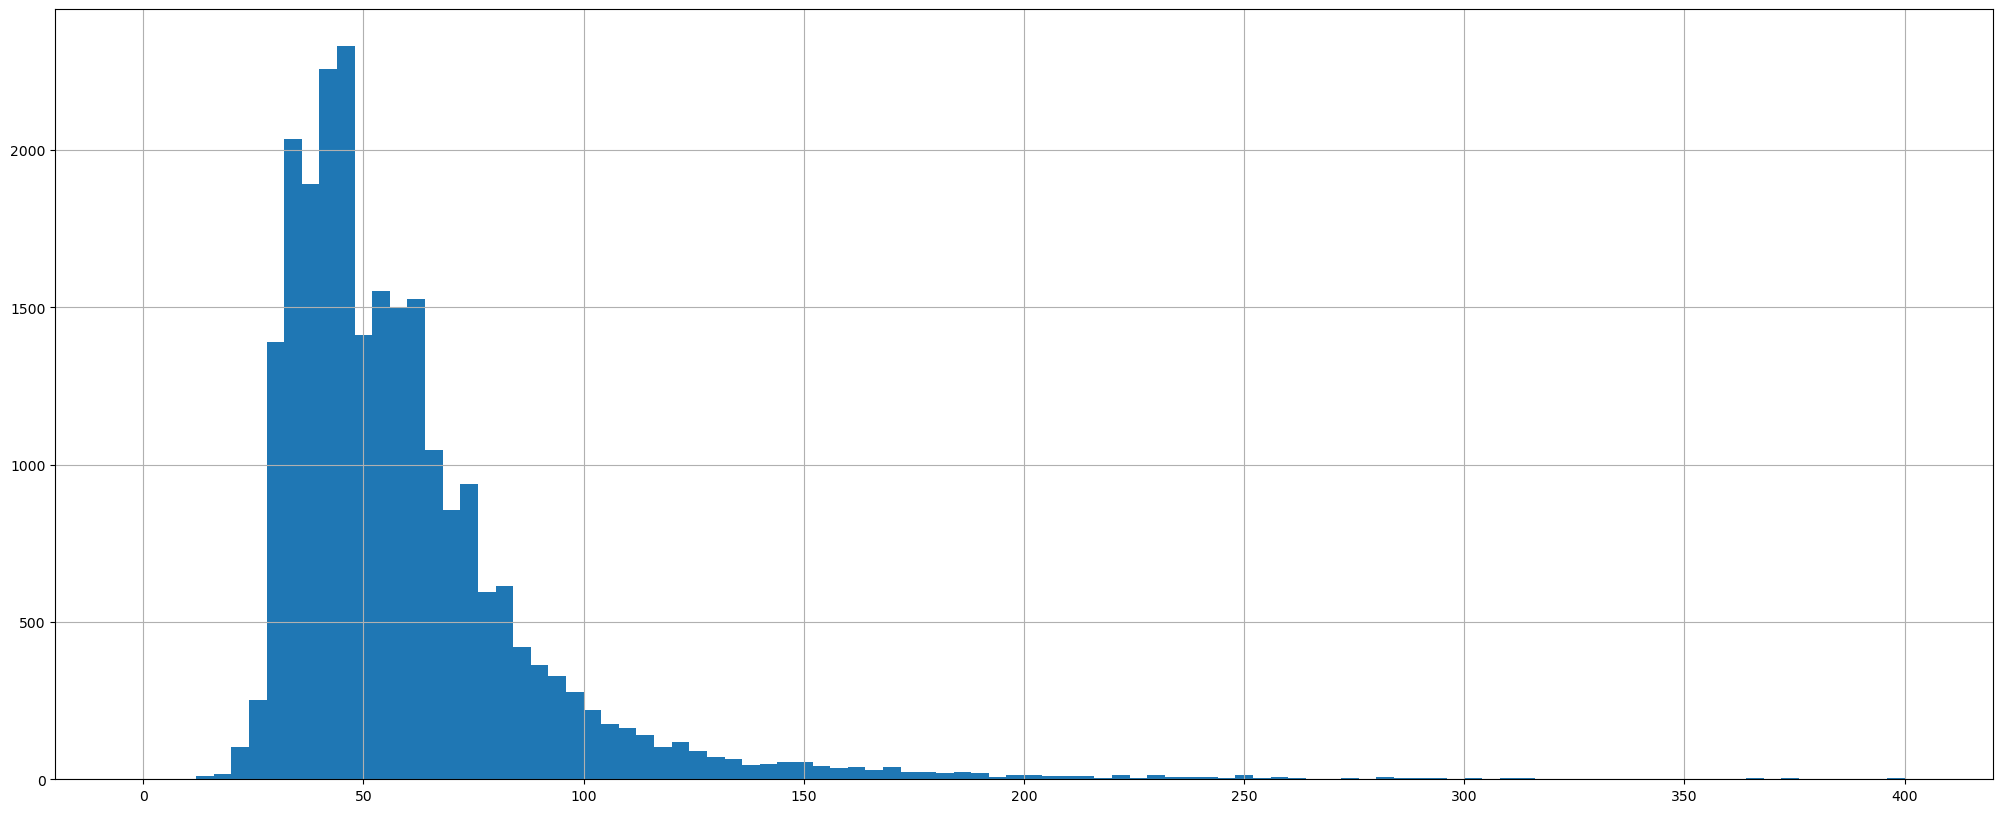

In [81]:
# вызовем функцию hist с количеством корзин (bins) 100, для значений (range) от 0 до 400 и размером (figsize) для комфортного 
# отображения данных:
data['total_area'].hist(bins=100, range=(0, 400), figsize=(25, 10))
plt.show()

По графику мы видим, что в датафрейме большая часть недвижимости имеют площадь примерно от 30 до 80 кв.м.

Значения ниже 10 кв.м. не встречаются. Значений от 10-20 мало - от силы пару десятков (видно при range=(0, 30)).

После того, как площадь недвижимости начинает переваливать за 80 кв.м., представленность объектов снижается. После 400 кв.м. можно найти отдельные объекты со значениями около 500, 600 и даже 900 кв.м., но их единицы (видно при range=(200, 1000)).

### 4.2 Изучим столбец living_area со значениями жилой площади недвижимости
Построим его гистограмму:

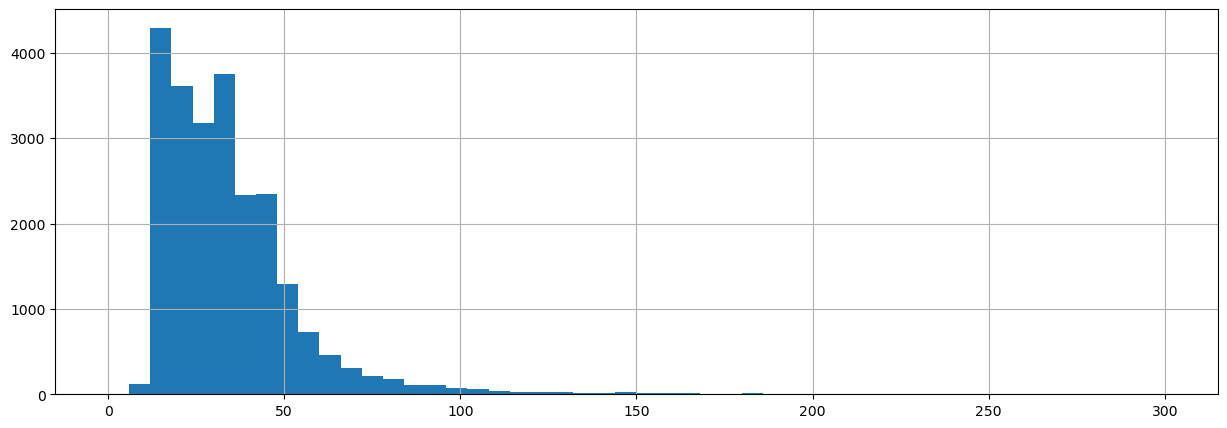

In [82]:
# вызовем функцию hist с количеством корзин (bins) 50, для значений (range) от 0 до 300 и выбранным размером (figsize) для 
# комфортного отображения данных:
data['living_area'].hist(bins=50, range=(0, 300), figsize=(15, 5))
plt.show()

По графику мы видим, что в датафрейме большая часть недвижимости имеет жилую площадь от 18 до 50 кв.м. После 50 кв. м. представленность объектов сильно снижается.

Больше примерно 420 кв.м. значений нет (видно при range=(200, 1000))

### 4.3 Изучим столбец kitchen_area со значениями площади кухни
Построим его гистограмму:

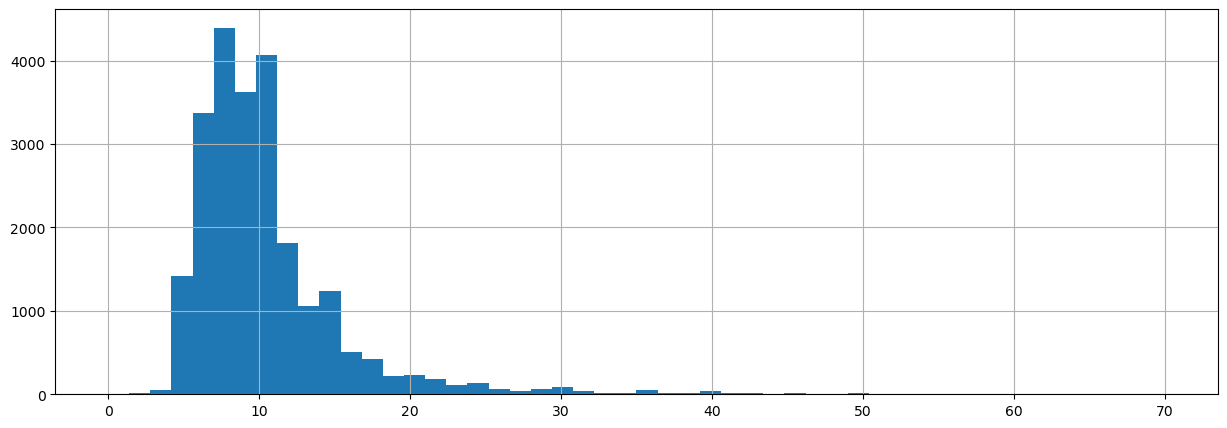

In [83]:
# вызовем функцию hist с количеством корзин (bins) 50, для значений (range) от 0 до 70 и выбранным размером (figsize) для 
# комфортного отображения данных:
data['kitchen_area'].hist(bins=50, range=(0, 70), figsize=(15, 5))
plt.show()

По графику мы видим, что в датафрейме большая часть недвижимости имеет площадь кухни от 5 до 15 кв.м.

При этом самые маленькие кухни от 2-5 метров встречаются редко. (видно при range=(0, 10)). Также как и нет кухонь больше 120 кв.м. (видно при range=(70, 150))

### 4.4 Изучим столбец last_price с ценами объектов 
Построим его гистограмму:

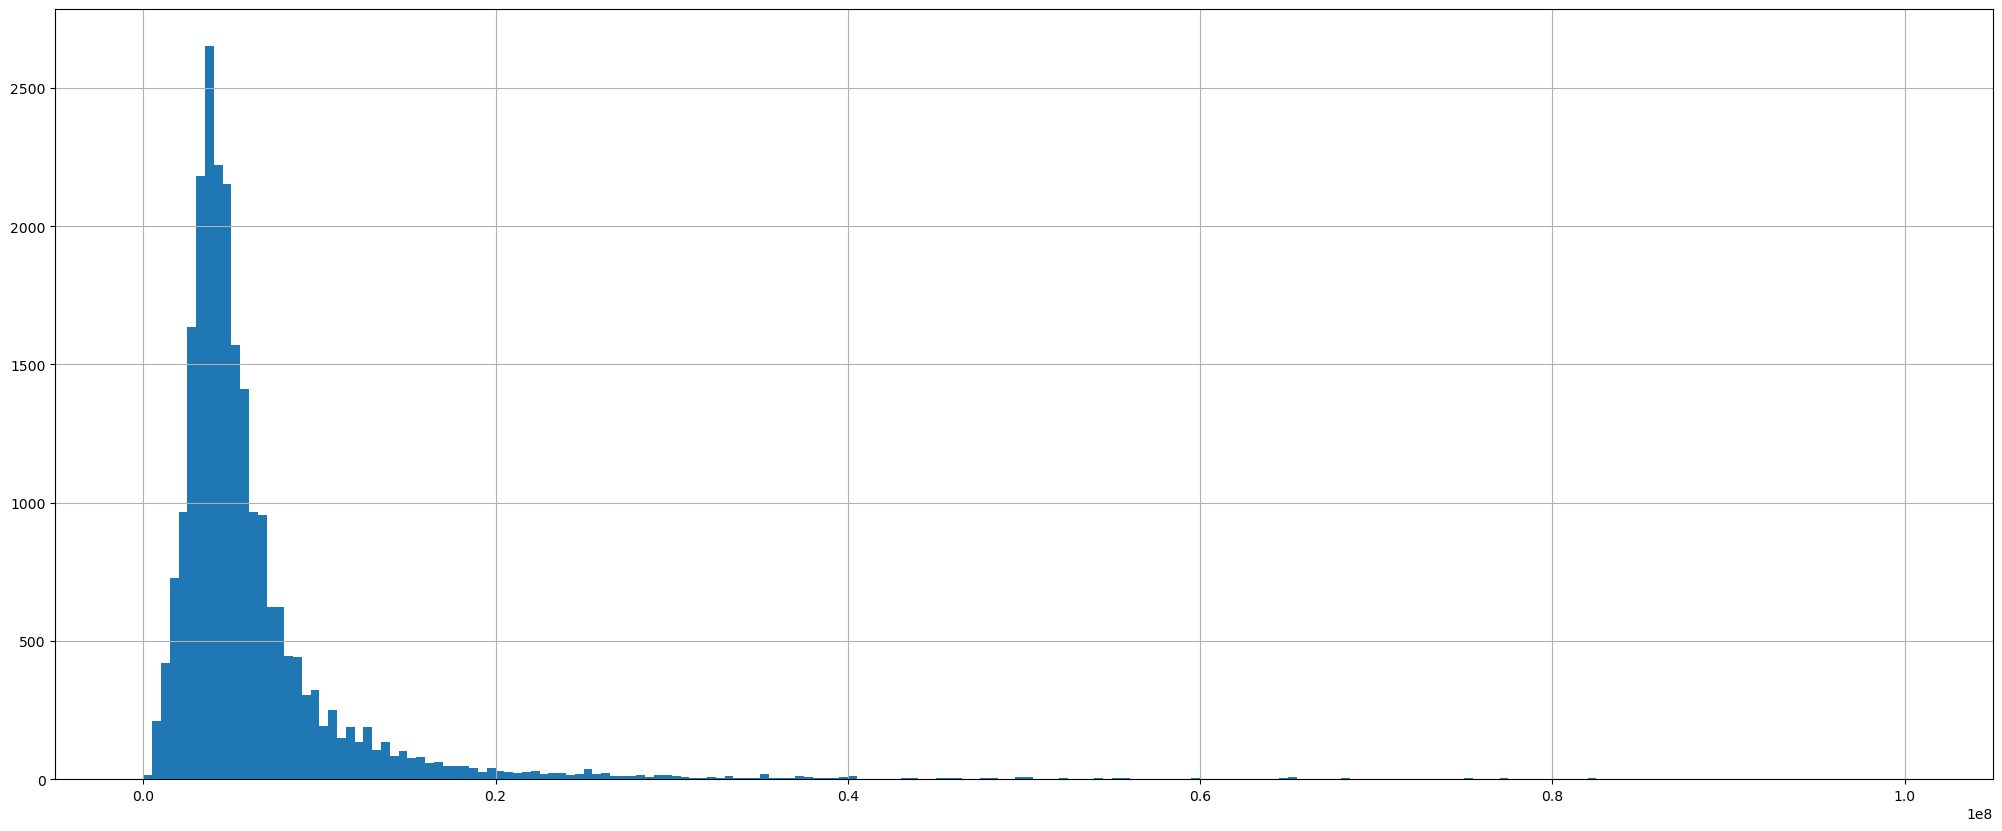

In [84]:
# вызовем функцию hist с количеством корзин (bins) 200, для значений (range) от 0 до 100000000 - в этом диапазоне будет видна 
# подавляющая часть квартир, и выбранным размером (figsize) для комфортного отображения данных:
data['last_price'].hist(bins=200, range=(0, 100000000), figsize=(25, 10))
plt.show()

По гистограмме видим, что наибольшая часть недвижимости находится в диапазоне цен от 2млн. до 7.5млн (лучше всего это видно при  range=(0, 10000000))

Но есть и отдельные выбросы. Например, можно найти недвижимость якобы за 12 тыс. (при range=(0, 20000)) и квартиры за 300+, 400+ и даже 700+ млн. (при range=(50000000, 800000000)) Это значения близкие к нереальным. Возможны, как ошибки в записи цены, так и намеренные вбросы с целью увеличить или, напротив, уменьшить стоимость жилья в схожем сегменте.

Квартиры стоимостью выше 40 млн. тоже встречаются редко, но есть. Однако, такие объекты действительно могут существовать в реальности (сегмент элитного жилья).

### 4.5 Оценим столбец rooms (количество комнат)

Построим гистограмму для него:

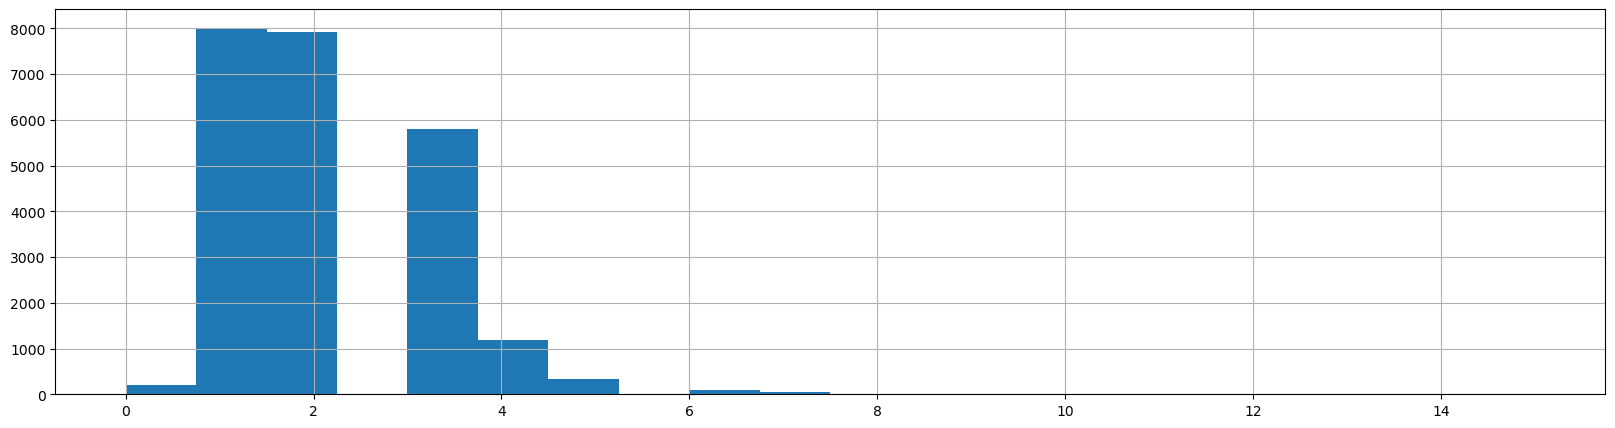

In [85]:
# вызовем функцию hist с количеством корзин (bins) 20, для значений (range) от 0 до 15 - в этом диапазоне будет видна 
# подавляющая часть квартир с разной комнатностью, и выбранным размером (figsize) для комфортного отображения данных:
data['rooms'].hist(bins=20, range=(0, 15), figsize=(20, 5))
plt.show()

Большая часть объектов недвижимости имеют от 1 до 3 комнат. Также встречаются объекты с 4 комнатами, но уже пореже. Совсем редко можно найти квартиры от 6+ комнат.

Смущает наличие квартир с 0 комнат, но так могут позиционировать себя студии, где в качестве комнаты выступает кухня-гостиная.

### 4.6 Взглядем на столбец ceiling_height (высота потолков)
Построим его гистограмму:

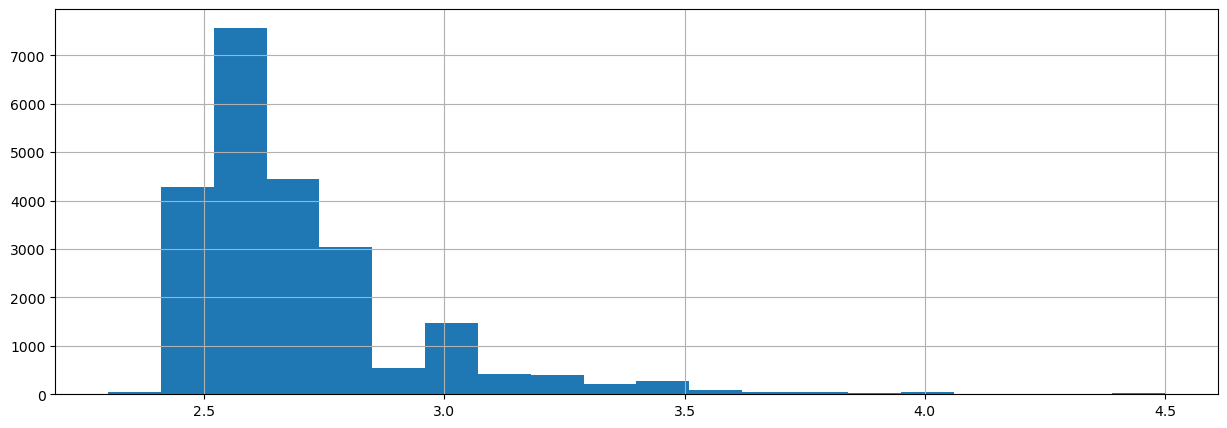

In [86]:
# вызовем функцию hist с количеством корзин (bins) 20, для значений(range) от 2.3, 4.5 - ранее мы сами установили такие пределы,
# и выбранным размером (figsize) для комфортного отображения данных:
data['ceiling_height'].hist(bins=20, range=(2.3, 4.5), figsize=(15, 5))
plt.show()

Мы сами выше ограничили размер потолка рамками 2.3 и 4.5 метров, поэтому потолки не будут выбиваться из этих значений.

В подавляющем большинстве квартир встречается потолок от 2.4 - 2.9 метров. Но отдельные выбросы встречаются как на значениях 2.3-2.4, так и на значениях больше 3,5.

### 4.7 Проанализируем столбец floor (этаж квартиры)
Построим его гистограмму:

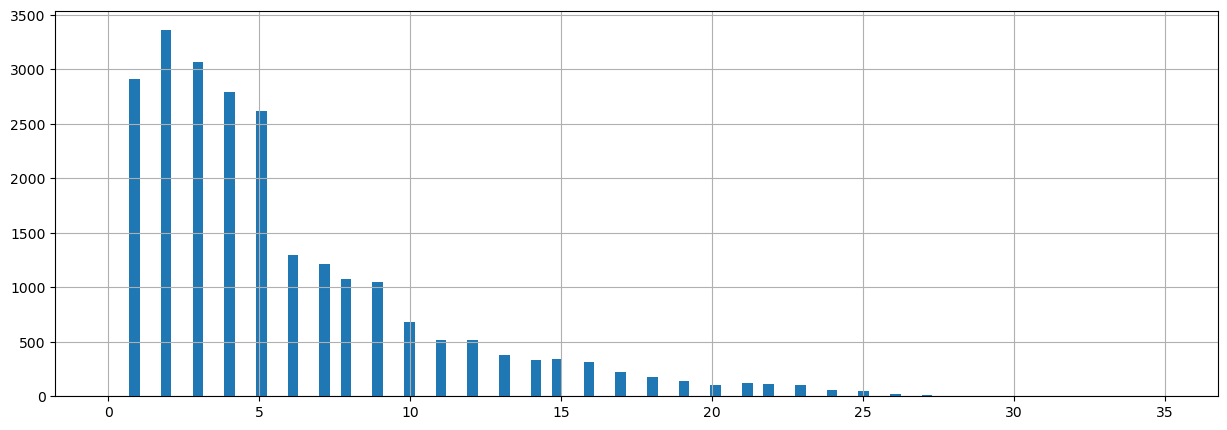

In [87]:
# вызовем функцию hist с количеством корзин (bins) 100, для значений(range) от 0 до 35 - так будет видна подавляющая часть
# квартир на разных этажах и выбранным размером (figsize) для комфортного отображения данных:
data['floor'].hist(bins=100, range=(0, 35), figsize=(15, 5))
plt.show()

Абсолютное большинство квартир располагаются на этаже от 1 до 10. При этом наибольшее количество объектов в сегменте этажности от 1 до 5.

Представленность объектов выше 10 этажа значительно ниже, но они есть вплоть до отдельных значений 30+ (видно при range=(20, 35)). Но выше 33 этажа квартир в датафрейме нет.

### 4.8 Взглянем на столбец floor_type
Построим его гистограмму:

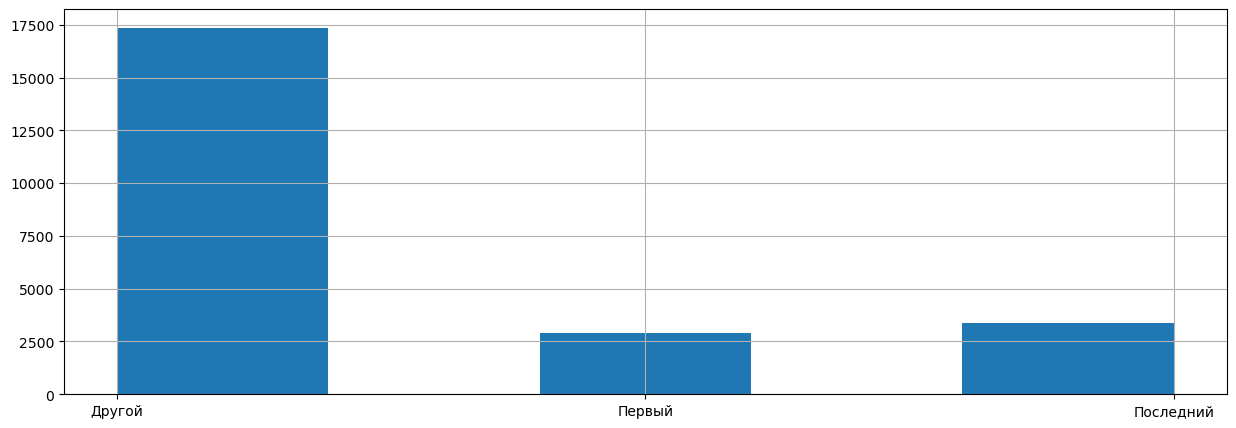

In [88]:
# вызовем функцию hist с количеством корзин (bins) 5 и выбранным размером (figsize) для комфортного отображения данных:
data['floor_type'].hist(bins=5, figsize=(15, 5))
plt.show()

По гистограмме видим, что с абсолютным отрывом лидирует столбец "*Другой*" - именно таких значений в датафрейме больше всего. На первом и последнем этаже количество квартир примерно одинаково.

### 4.9 Проанализируем общую этажность домов при помощи столбца floors_total
Строим его гистограмму:

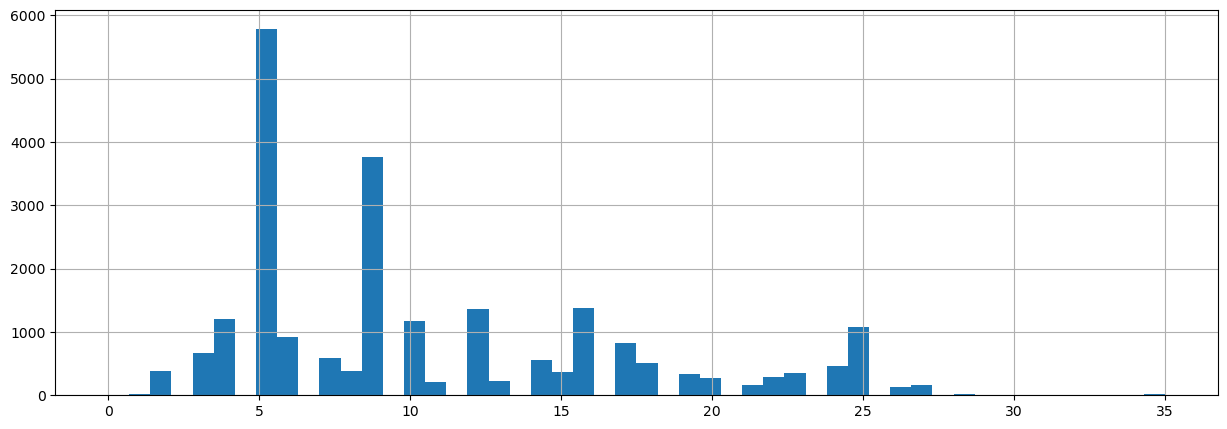

In [89]:
# вызовем функцию hist с количеством корзин (bins) 50, для значений(range) от 0 до 35 - так будет видна подавляющая часть
# домов разной этажности и выбранным размером (figsize) для комфортного отображения данных:
data['floors_total'].hist(bins=50, range=(0, 35), figsize=(15, 5))
plt.show()

Видим, что наибольшее количество квартир из датафрейма находятся в 5 и 9 этажных домах.

Но есть отдельные выбросы: встречаются значения с одноэтажными домами и пара явно не реальных значений с 50-60 этажами (видно при range=(35, 60)), в то время как максимальная зафиксированная этажность жилого дома в СПб - 35 этажей.

У этой гистограммы, в отличие от предыдущих, не нормальное "колокольное" распределение, а многопиковое распределение. Однако, конкретно для этажей это скорее нормально - в Санкт-Петербурге и Ленобласти много домов "старого фонда" с низкой этажностью (2-4 этажа) и "панелек" с типовой этажностью 5-9-12 этажей. В последние годы растет и количество высокоэтажных новостроек с разной этажностью.

### 4.10 Вычислим насколько далеко объекты недвижимости из датафрейма расположены от центра (в метрах)
Строим гистограмму:

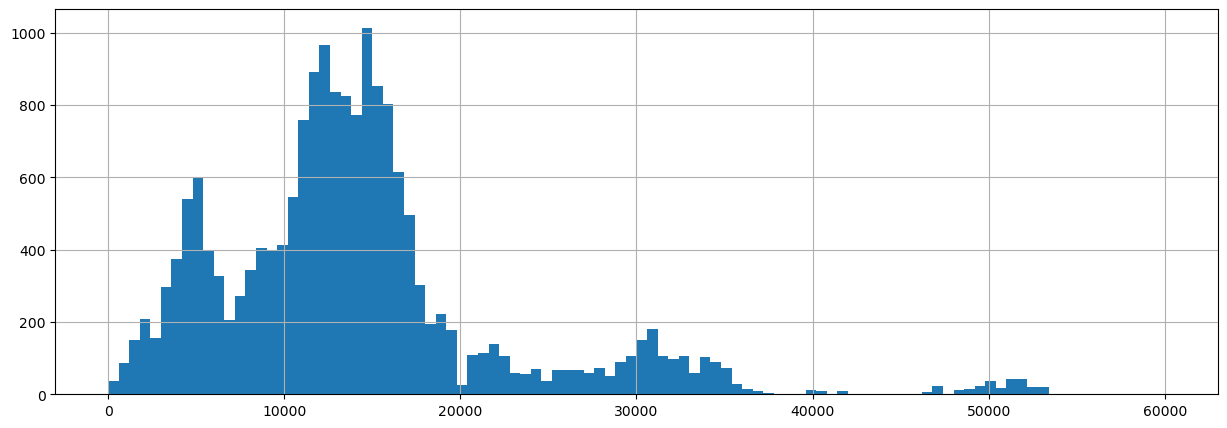

In [90]:
# вызовем функцию hist с количеством корзин (bins) 100, для значений(range) от 0 до 60000 - так будет видна подавляющая часть
# квартир и выбранным размером (figsize) для комфортного отображения данных:
data['cityCenters_nearest'].hist(bins=100, range=(0, 60000), figsize=(15, 5))
plt.show()

Видим в целом нормальное распределение с отдельными выбросами.

Наибольшая часть квартир в датафрейме находится на расстоянии от центра в пределах 10000-18000 метров. Это соответствует подавляющему большинству локаций черте СПб.
При этом солидная часть квартир находится как достаточно близко к центру СПб (3000-6000 м.), так и довольно далеко (28000-34000 м.) - это уже скорее локации из Ленобласти. Довольно много выбросов на значениях в районе 50000 м.

### 4.11 Исследуем столбец parks_nearest, чтобы узнать на каком расстоянии от квартир находится ближайший парк 
Строим гистограмму:

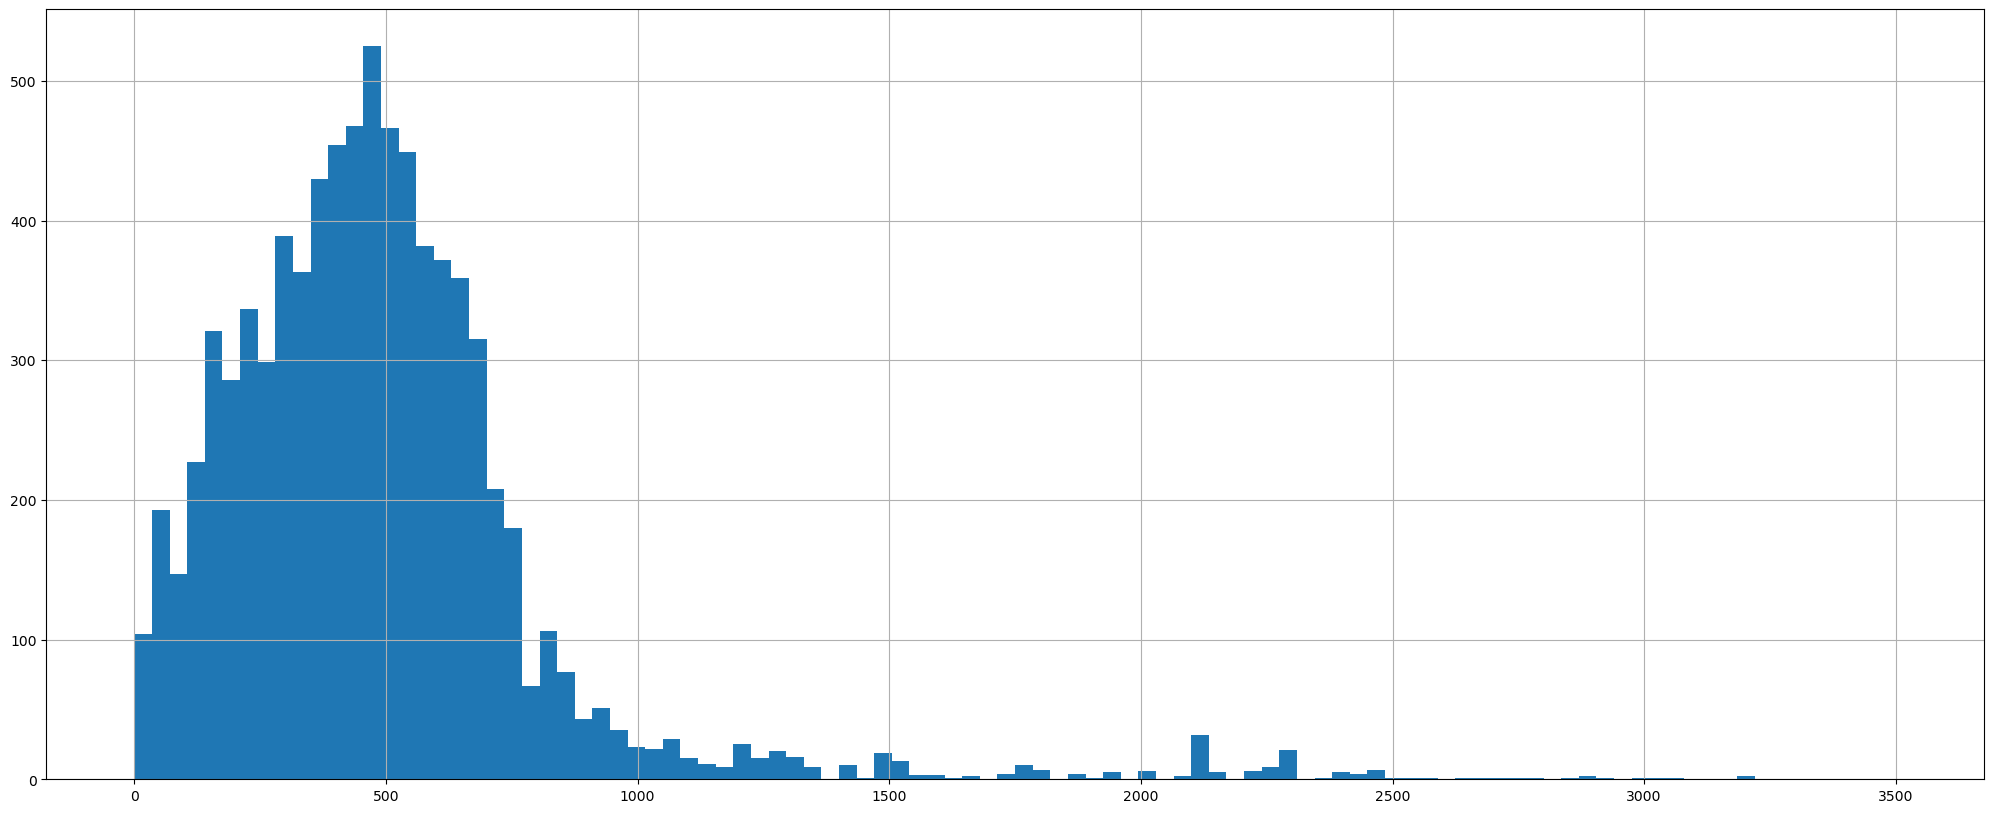

In [91]:
# вызовем функцию hist с количеством корзин (bins) 100, для значений(range) от 1 до 3500 и выбранным размером (figsize) для 
# комфортного отображения данных:
data['parks_nearest'].hist(bins=100, range=(0, 3500), figsize=(25, 10))
plt.show()

Видим, что Петербург - город парков. 

Большая часть квартир находится на расстоянии примерно 100 и до 700 м. до ближайшего парка. Мало кто живёт в квартире, которая располагается более чем в 1000 м. от парка. При этом встречаются отдельные объекты недвижимости, находящиеся на расстоянии от парка вплоть до 3000+ м.

### 4.12 Исследуем столбец airports_nearest, чтобы понять насколько далеко квартиры располагаются от аэропортов
Строим гистограмму:

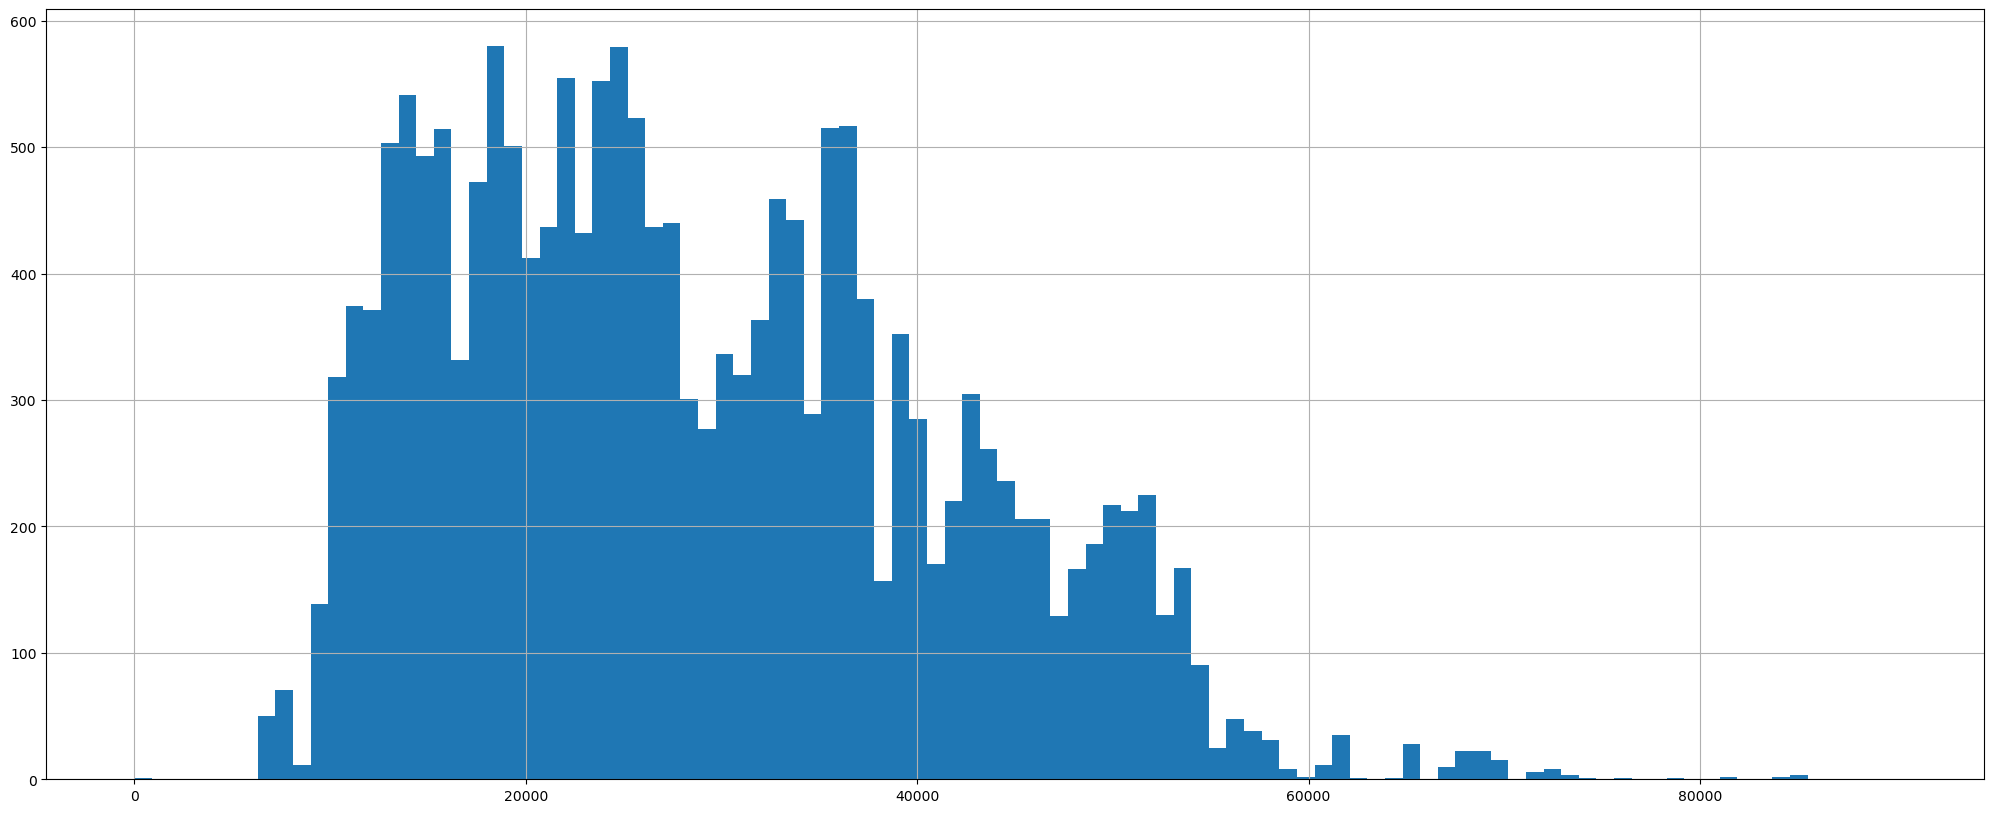

In [92]:
# вызовем функцию hist с количеством корзин (bins) 100, для значений(range) от 1 до 90000 и выбранным размером (figsize) для 
# комфортного отображения данных:
data['airports_nearest'].hist(bins=100, range=(0, 90000), figsize=(25, 10))
plt.show()

Видим широкий разброс значений. Большая часть квартир находится на расстоянии от 7000 до 40000 м.
В то же время видны отдельные значительные пики 42-52тыс. м. и выбросы после 60 тыс. м. 

Для картографических данных это вполне нормально, так как квартиры в разных частях города будут закономерно принадлежать к разным пикам. Странный только один маленький выброс возле 0, показывающий, что есть квартира прям в самом аэропорте.

### 4.13 При помощи столбца week_day изучим дни недели, в которые публиковались объявления

Строим гистограмму:

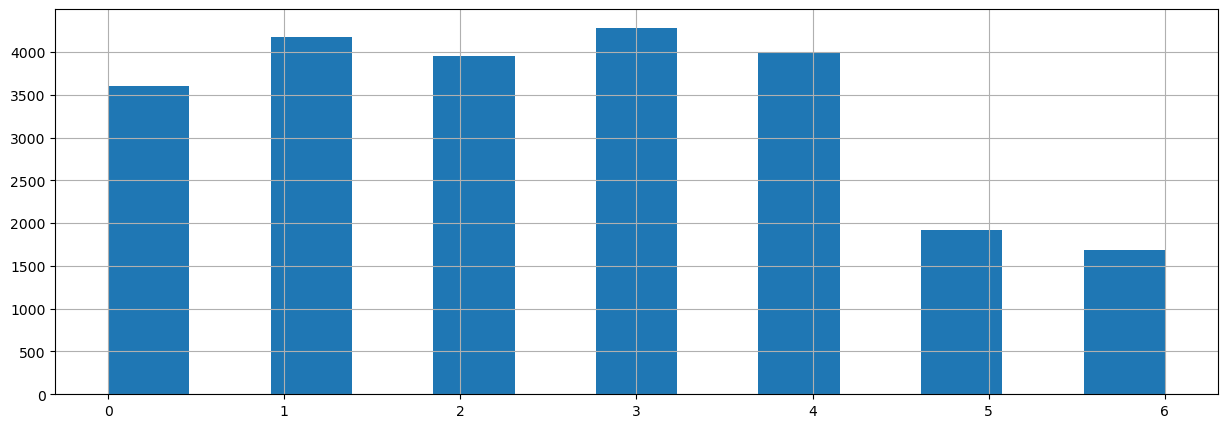

In [93]:
# вызовем функцию hist с количеством корзин (bins) 13 и выбранным размером (figsize) для комфортного отображения данных:
data['week_day'].hist(bins=13, figsize=(15, 5))
plt.show()

Видим, что большая часть объявлений опубликована на буднях. При этом самые активные для публикаций дни: вторник(1) и четверг(3).
Примерно в 2 раза меньше публикуется объявлений на выходных. Это объяснимо - на выходных люди стремятся отдыхать, а не решать какие-то задачи.

### 4.14 Изучим столбец month, отражающий в каком месяце подавались объявления
Построим гистограмму для него:

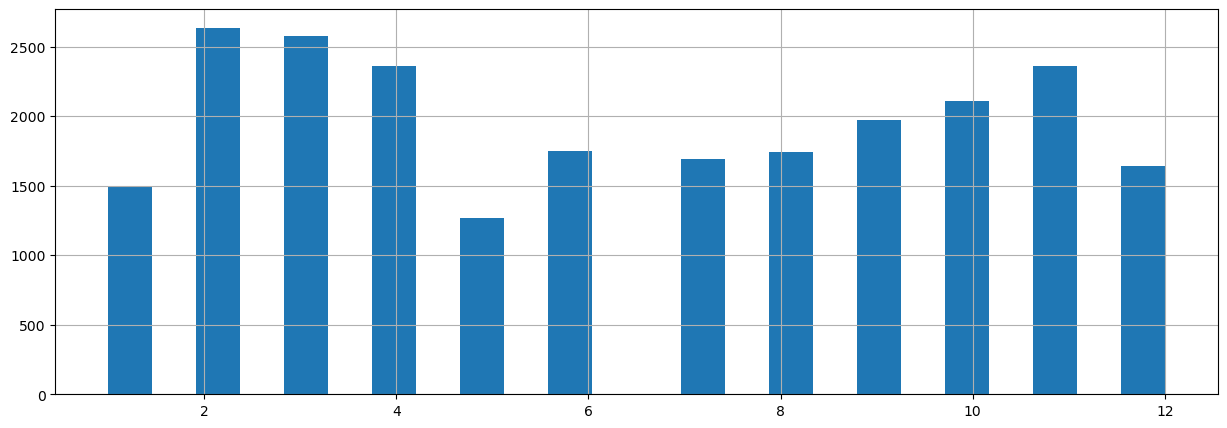

In [94]:
# вызовем функцию hist с количеством корзин (bins) 24 и выбранным размером (figsize) для комфортного отображения данных:
data['month_submit'].hist(bins=24, figsize=(15, 5))
plt.show()

Видим, что больше всего публикуется объявлений с февраля по апрель (2-4). С мая по август (5-8) наблюдается снижение количества публикаций. После чего с сентября до ноября включительно (9-11) публикации опять растут, пока в декабре-январе (12-1) их количество снова не снизится.

Такая картина, судя по всему, связана с тем, что в период новогодних праздников (12-1), майских выходных и летних отпусков (5-8) люди не хотят заниматься рутинными делами, вроде продаж недвижимости.

### 4.15 Чтобы узнать сколько времени занимает продажа квартиры, изучим столбец days_exposition:

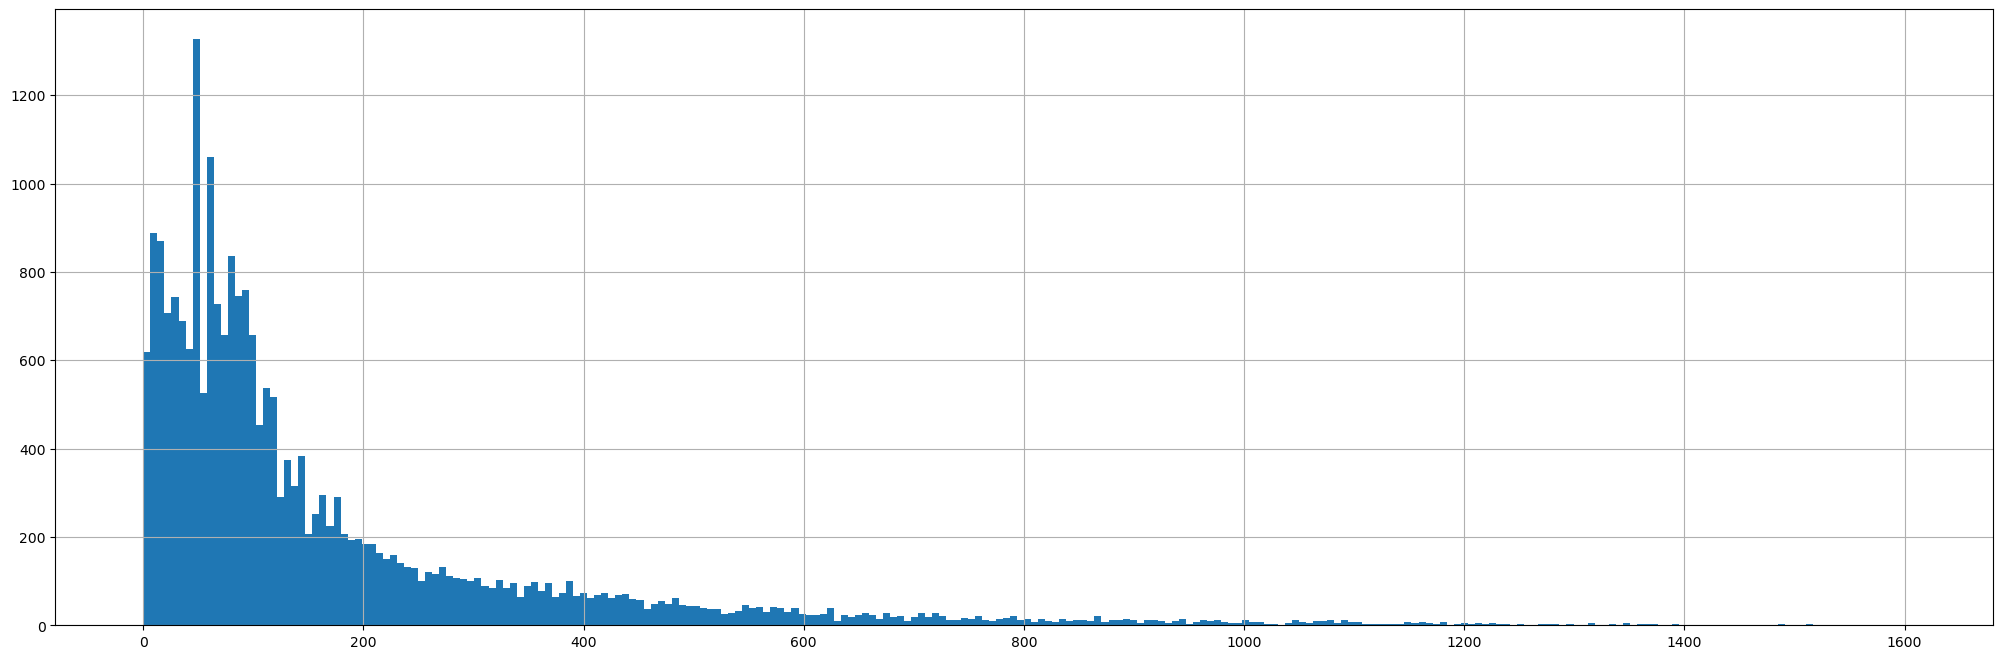

In [95]:
# вызовем функцию hist с количеством корзин (bins) 100 для значений (range) от 0 до 1600 и выбранным размером (figsize) для 
# комфортного отображения данных:
data['days_exposition'].hist(bins=250, range=(0, 1600), figsize=(25, 8))
plt.show()

Большая часть квартир продается в течение первых 200 дней. 

При этом если рассматривать гистограмму при range=(40, 65) видно, что есть значительные и выбивающиеся из общей картины пики на 45 и 60 днях продажи. Скорее всего они связаны с тем, что квартиру, возможно и не продавали в этот день - просто заканчивался срок публикации объявления. Оно снималось и система учитывала это как "продажу".

In [96]:
# Чтобы посчитать среднее и медиану, вызовем метод describe():
data['days_exposition'].describe()

count    23307.000000
mean       172.852083
std        209.196088
min          1.000000
25%         45.000000
50%         94.000000
75%        209.500000
max       1580.000000
Name: days_exposition, dtype: float64

Получили значения довольно хорошо описывающие нашу гистограмму: из-за пиков и длинного хвоста с большим разбросом значений стандартное отклонение (std) очень велико, а среднее арифметическое дней продажи почти в два раза превышает медиану и вряд ли является той величиной, на которую стоит ориентироваться.
На медиану же такие выбросы настолько сильно не влияют - она здесь лучше отражает за какое время в среднем продаются квартиры - это срок в 94 дня.

Также, по describe можно сделать выводы о том, что быстрой можно считать продажу в пределах 1 квартиля (25%) - 45 дней. Судя по значению min, кому-то удавалось продать квартиру прямо в первый день.

При этом те квартиры, которые продаются 209 дней и дольше будут считаться теми объектами, что продаются необычно долго. Максимальный срок продажи занял 1580 дней.

## 5 Изучим какие факторы больше всего влияют на общую (полную) стоимость объекта

### 5.1 Построим график связи между ценой и общей площадью:

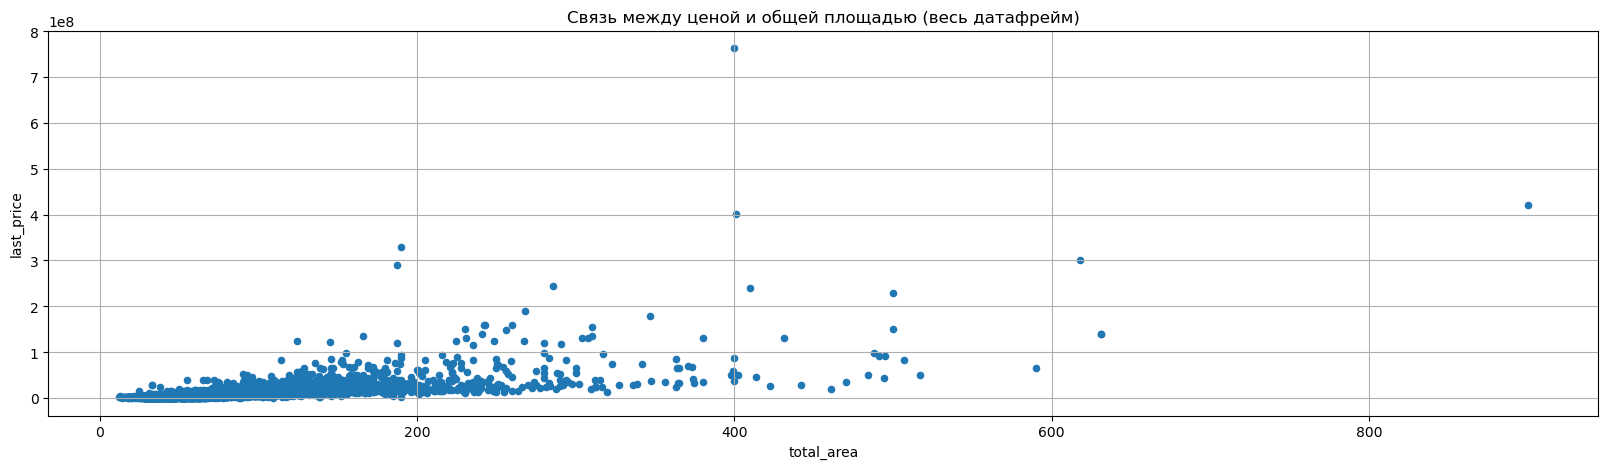

In [97]:
# Для этой цели вызовем функцию plot с типом scatter, которая построит для нас диаграмму рассеяния, отражающую зависимость цены
# от общей площади. Для большей нагрядности укажем, что нам нужна сетка (grid) и предпочитаемый размер (figsize):
data.plot(kind='scatter', x='total_area', y='last_price', grid=True, figsize=(20, 5), 
          title='Связь между ценой и общей площадью (весь датафрейм)')
plt.show()

По графику действительно видно, что с увеличением площади растёт и цена, но не так наглядно, как хотелось бы.
Также, есть выбросы. Тому может быть несколько причин:
1. В отдельных случаях это может быть нормально - квартиры одинаковой площади могут иметь разную "начинку", находиться в разных частях города и стоить очень по-разному;
2. В датафрейме есть ошибки в написании цены;
3. Намеренное занижение или завышение стоимости жилья, чтобы влиять на цены.

Учитывая, что доля чрезмерных всплесков особенно заметна для квартир, чья стоимость превышает 100 млн., попробуем ограничить максимальную стоимость этим значением и посмотрим, как теперь будет выглядеть график:

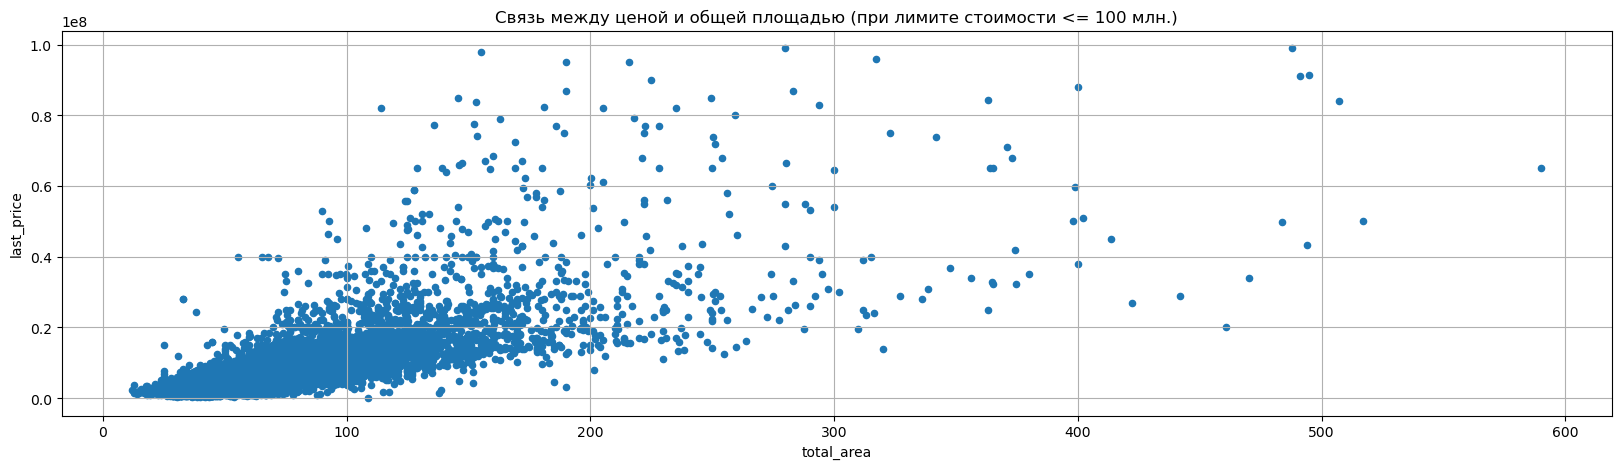

In [98]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу функцию plot с типом scatter, 
# которая построит для нас диаграмму рассеяния, отражающую зависимость цены от общей площади. Для большей нагрядности укажем, 
# что нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .plot(kind='scatter', x='total_area', y='last_price', grid=True, figsize=(20, 5), 
          title='Связь между ценой и общей площадью (при лимите стоимости <= 100 млн.)')
)
plt.show()

Теперь зависимость цены от площади показана намного нагляднее. Для следующих расчётов зависимости тоже лучше использовать ограничение <100 млн. - стоимость выше этого числа выглядит практически нереальной, даже для такого достаточного дорогого города, как Санкт-Петербург. Срез позволит избежать значительного влияния выбросов на параметры взаимосвязи цены и различных характеристик квартиры.

Также, рассчитаем корреляцию Пирсона, чтобы увидеть взаимосвязь в числовом выражении, при помощи `corr`:

In [99]:
# Вызовем метод corr, который рассчитает взаимосвязи между общей площадью и ценой, где чем ближе значения к -1 или +1 - тем 
# сильнее связь между данными. Если величина близка к 0 - связи нет:
print(data['total_area'].corr(data['last_price']))

0.6535810085611218


Корелляция Пирсона показывает, что связь действительно есть и достаточно сильная. При этом очевидно, что общая площадь - явно не единственный фактор, который влияет на стоимость квартиры.

### 5.2 Построим график связи между ценой и жилой площадью (living_area):

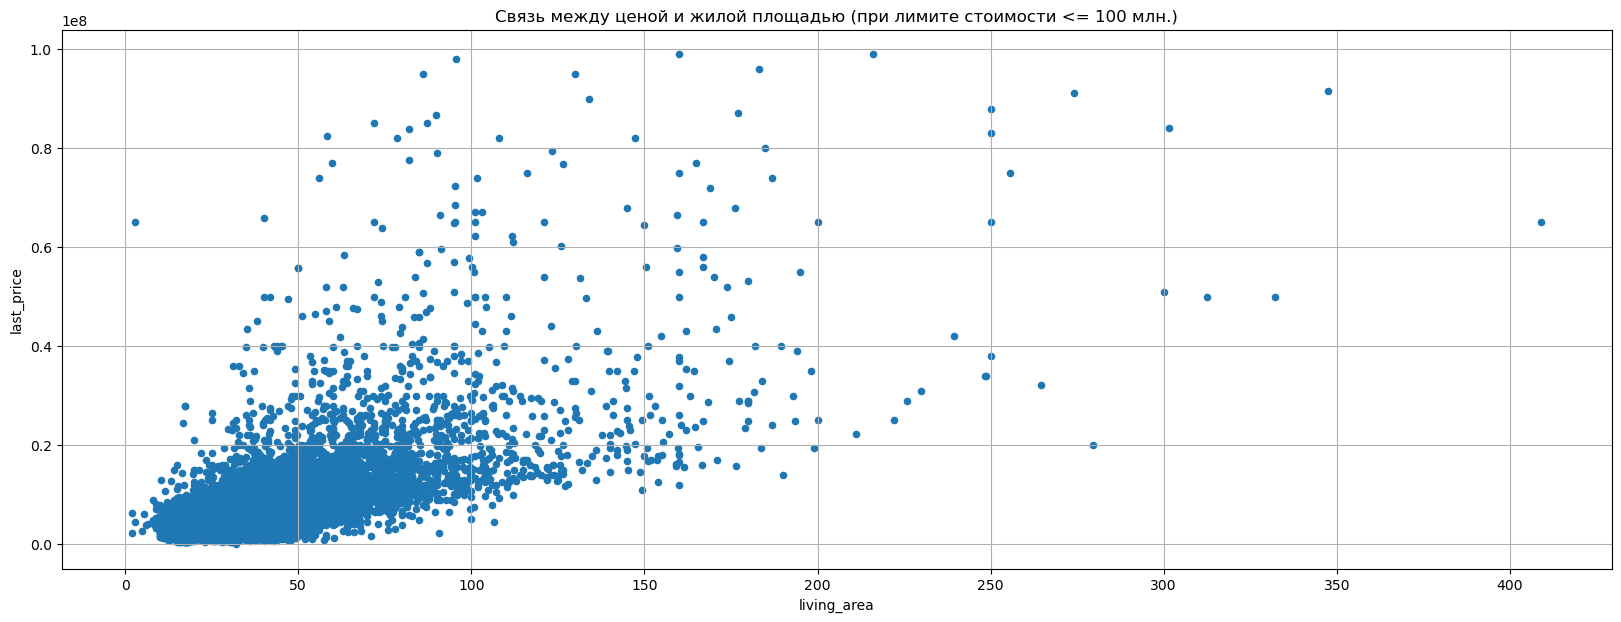

In [100]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу функцию plot с типом scatter, 
# которая построит для нас диаграмму рассеяния, отражающую зависимость цены от общей площади. Для большей нагрядности укажем, 
# что нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .plot(kind='scatter', x='living_area', y='last_price', grid=True, figsize=(20, 7), 
          title='Связь между ценой и жилой площадью (при лимите стоимости <= 100 млн.)')
)
plt.show()

Как и в случае с графиком зависимости цены об общей площади, видим, что по мере увеличения жилой площади возрастает и средняя цена объекта.
Также, проверим связь между стоимостью квартиры и жилой площадью при помощи корреляции Пирсона:

In [101]:
# Вызовем метод corr, который рассчитает взаимосвязи между общей площадью и ценой, где чем ближе значения к -1 или +1 - тем 
# сильнее связь между данными. Если величина близка к 0 - связи нет:
print(data['living_area'].corr(data['last_price']))

0.5714593908244239


Видим, что связь между ценой и жилой площадью есть, но слабее - жилая площадь немного меньше влияет на цену.

### 5.3 Построим график связи между ценой и площадью кухни:

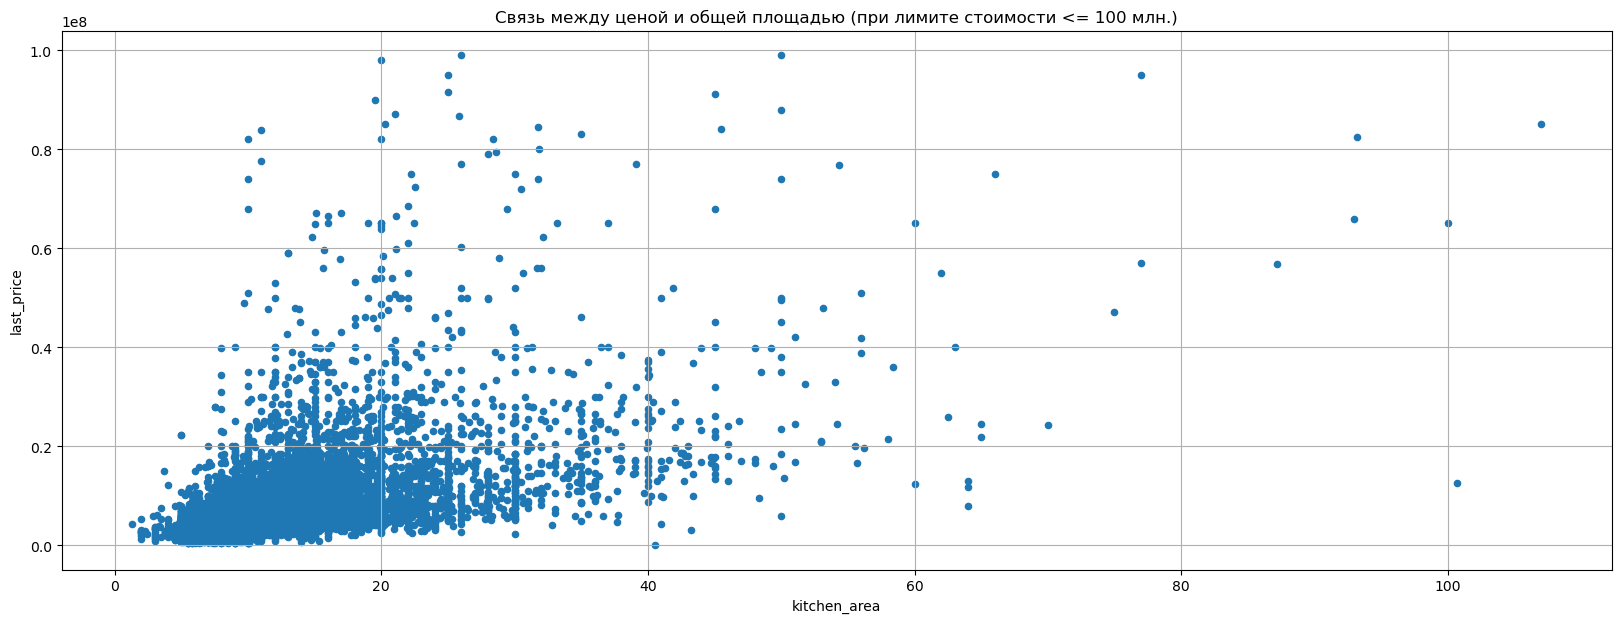

In [102]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу функцию plot с типом scatter, 
# которая построит для нас диаграмму рассеяния, отражающую зависимость цены от общей площади. Для большей нагрядности укажем, 
# что нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .plot(kind='scatter', x='kitchen_area', y='last_price', grid=True, figsize=(20, 7), 
          title='Связь между ценой и общей площадью (при лимите стоимости <= 100 млн.)')
)
plt.show()

Здесь связь тоже прослеживается, но она уже заметно слабее по сравнению с зависимостью цены от общей площади.

Рассчитаем корреляцию Пирсона, чтобы посмотреть зависимость в числовом выражении:

In [103]:
# Вызовем метод corr, который рассчитает взаимосвязи между общей площадью и ценой, где чем ближе значения к -1 или +1 - тем 
# сильнее связь между данными. Если величина близка к 0 - связи нет:
print(data['kitchen_area'].corr(data['last_price']))

0.487977178265818


По вычисленному значению видим, что связь действительно меньше. Она есть, но площадь кухни явно не в первых рядах по влиянию на стоимость квартиры.

### 5.4 Изучим взаимосвязь между количеством комнат и ценой:

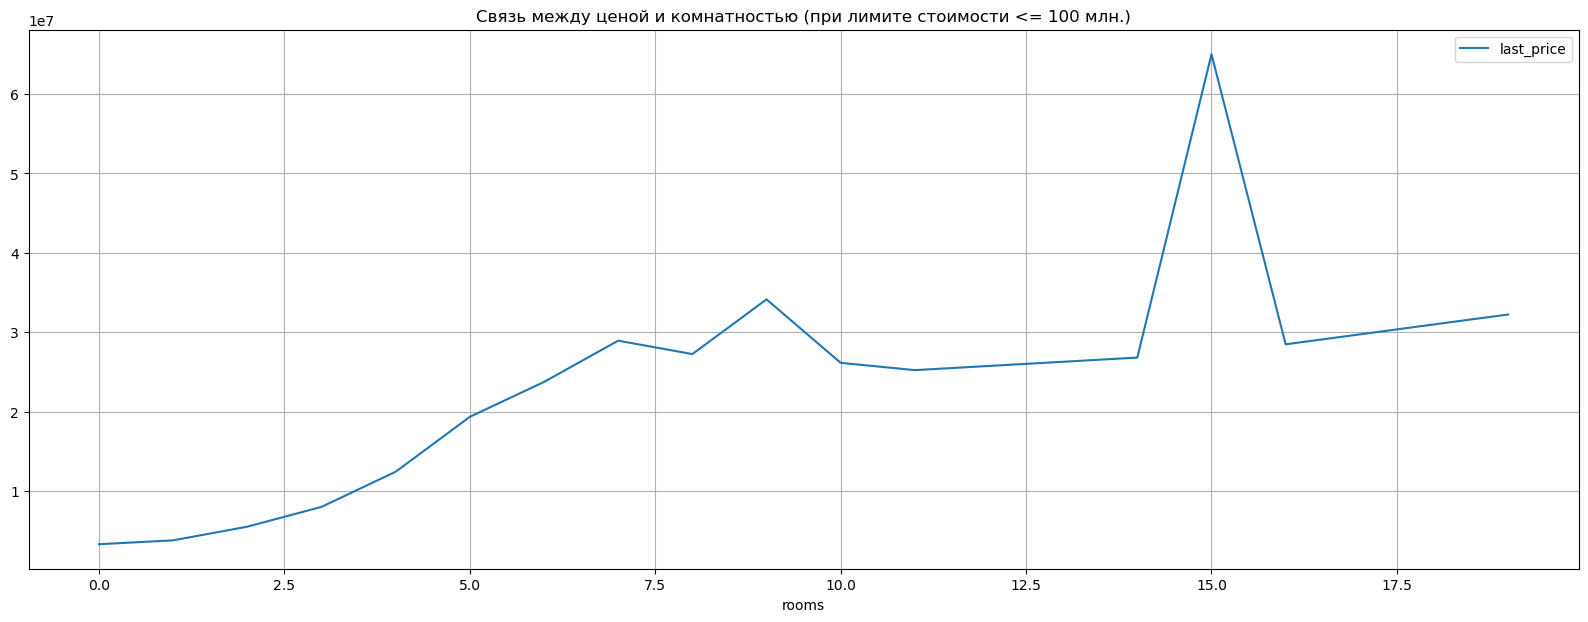

In [104]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу pivot_table для группировки 
# интересующих нас значений. К pivot_table применим функцию plot для построения графика. Для большей нагрядности укажем, что 
# нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .pivot_table(index='rooms', values='last_price')
    .plot(grid=True, figsize=(20, 7), title='Связь между ценой и комнатностью (при лимите стоимости <= 100 млн.)')
)
plt.show()

Видим, что комнатность умеренно влияет на стоимость до примерно 6 комнат. Дальше взаимосвязь уже не видна: примерно одинаково стоить могут объекты и с 8, и с 10, и с 16 комнатами, за исключением выброса на 15 комнатах.

Посчитаем корреляцию Пирсона, чтобы отразить связь между ценой и комнатностью в числовом выражении:

In [105]:
# Вызовем метод corr, который рассчитает взаимосвязи между общей площадью и ценой, где чем ближе значения к -1 или +1 - тем 
# сильнее связь между данными. Если величина близка к 0 - связи нет:
print(data['rooms'].corr(data['last_price']))

0.3631241665984552


Действительно видно, что связь уже не такая сильная по сравнению с такими характеристиками квартиры, как общая и жилая площадь, площадь кухни.

### 5.5 Изучим взаимосвязь между типом этажа и ценой:

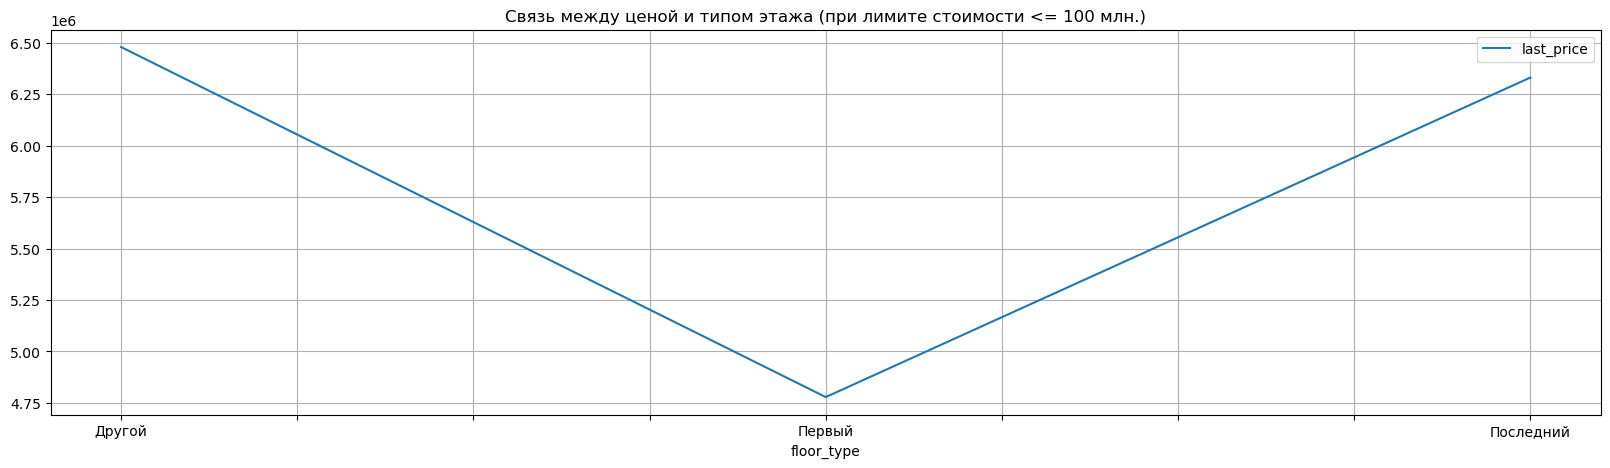

In [106]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу pivot_table для группировки 
# интересующих нас значений. К pivot_table применим функцию plot для построения графика. Для большей нагрядности укажем, что 
# нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .pivot_table(index='floor_type', values='last_price')
    .plot(grid=True, figsize=(20, 5), title='Связь между ценой и типом этажа (при лимите стоимости <= 100 млн.)')
)
plt.show()

Видим, что наиболее высоко оцениваются квартиры на любом этаже, кроме первого. "В цене" также и квартиры на последнем этаже, но несколько меньше, по сравнению с *другим* этажом.

### 5.6 Изучим взаимосвязь между днём подачи объявления и ценой:

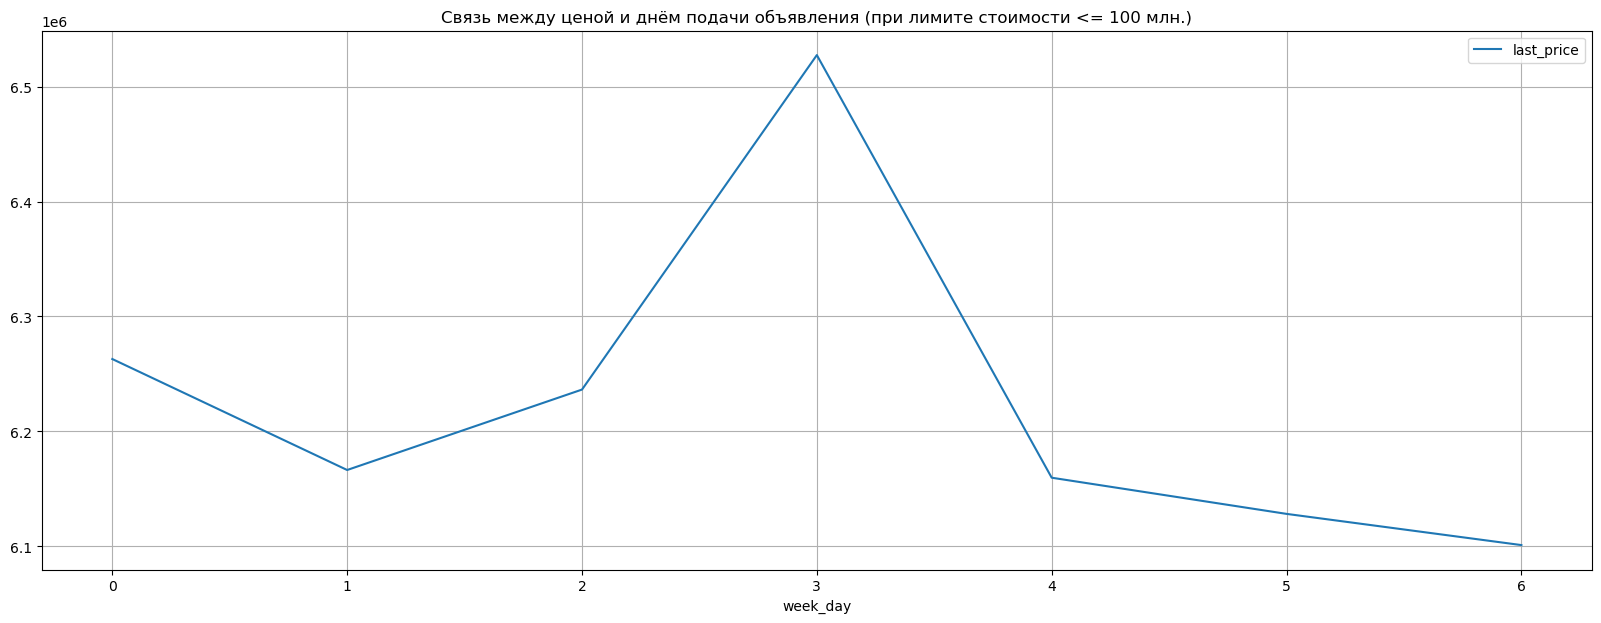

In [107]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу pivot_table для группировки 
# интересующих нас значений. К pivot_table применим функцию plot для построения графика. Для большей нагрядности укажем, что 
# нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .pivot_table(index='week_day', values='last_price')
    .plot(grid=True, figsize=(20, 7), title='Связь между ценой и днём подачи объявления (при лимите стоимости <= 100 млн.)')
)
plt.show()

Видим, что чаще всего наивысшую стоимость люди склонны устанавливать, если подают объявление в четверг (3).
Меньше всего просят за квартиру, подавая объявление в субботу (5) и особенно в воскресенье (6).

### 5.7 Изучим взаимосвязь между месяцем подачи объявления и ценой:

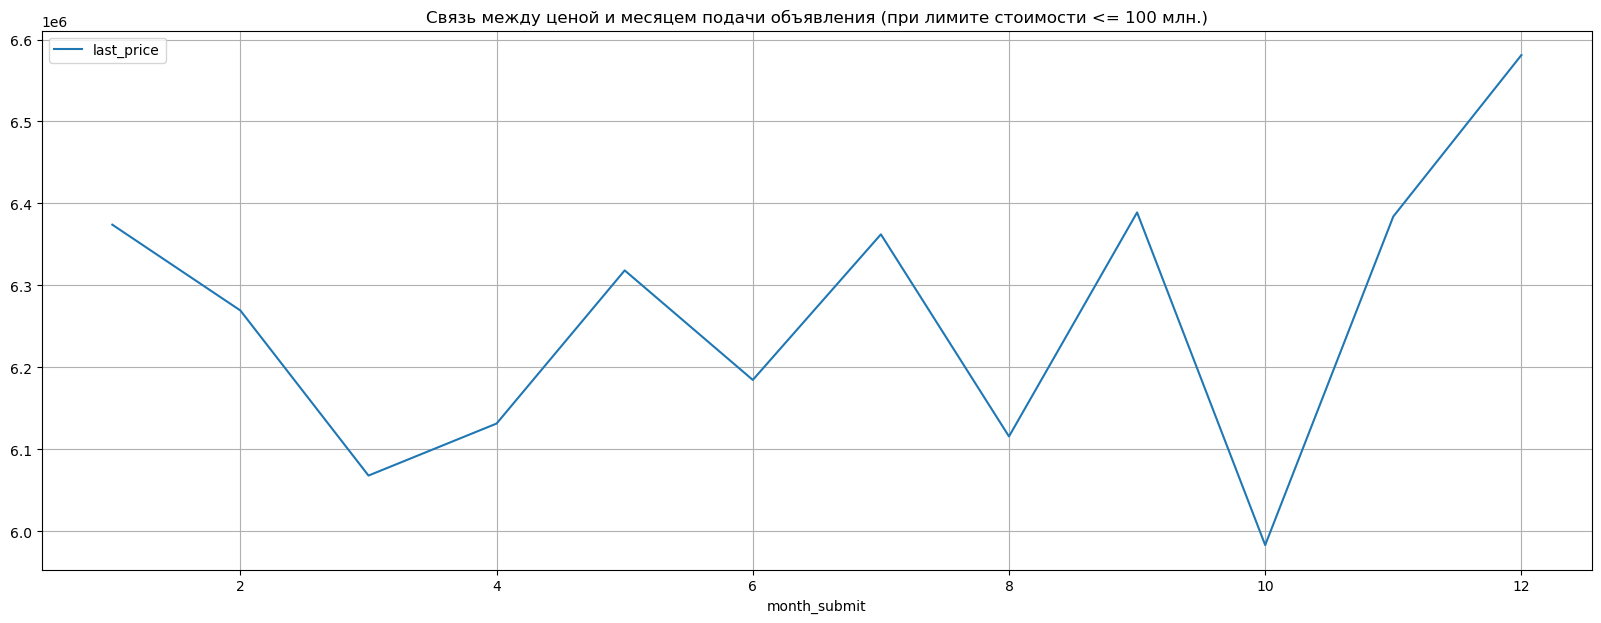

In [108]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу pivot_table для группировки 
# интересующих нас значений. К pivot_table применим функцию plot для построения графика. Для большей нагрядности укажем, что 
# нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .pivot_table(index='month_submit', values='last_price')
    .plot(grid=True, figsize=(20, 7), title='Связь между ценой и месяцем подачи объявления (при лимите стоимости <= 100 млн.)')
)
plt.show()

Наиболее низко оценивают квартиры, объявления по которым подавались в марте или в октябре. Дороже всего стоят квартиры, поданные в декабре и январе.

С апреля по ноябрь можно наблюдать примерно одинаковые пики то снижения средней цены объявления, то её увеличения. Это может быть связано с тем, что дорогие квартиры не продаются и объявления с ними переподаются заново в сервис через 45-60 дней.

### 5.8 Изучим взаимосвязь между годом подачи объявления и ценой:

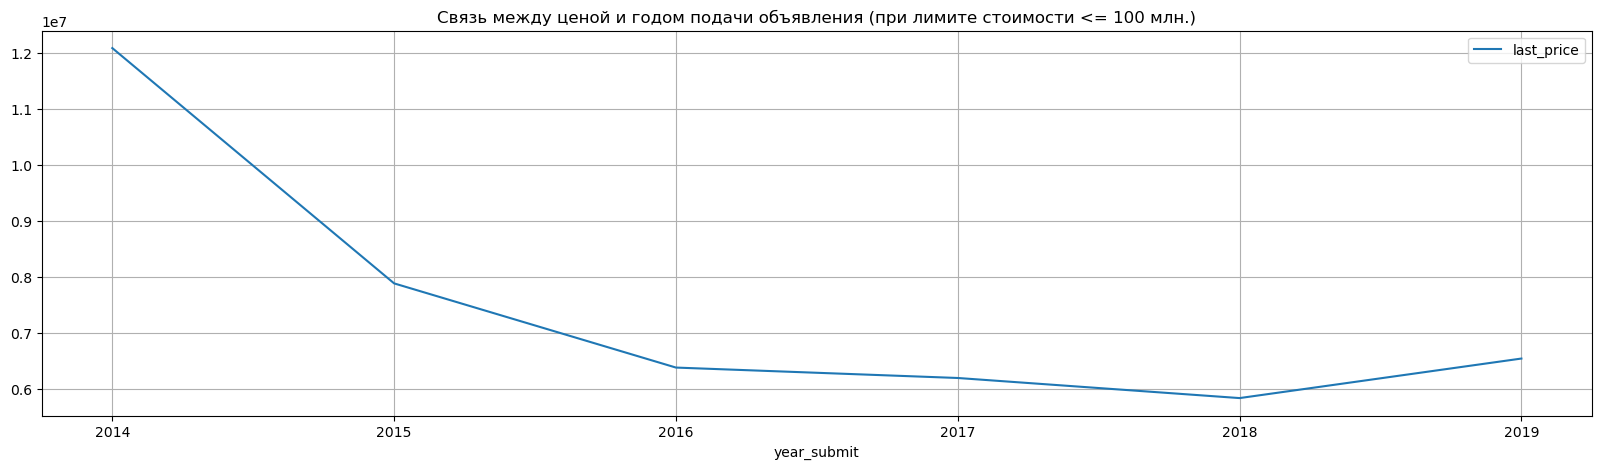

In [109]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу pivot_table для группировки 
# интересующих нас значений. К pivot_table применим функцию plot для построения графика. Для большей нагрядности укажем, что 
# нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .pivot_table(index='year_submit', values='last_price')
    .plot(grid=True, figsize=(20, 5), title='Связь между ценой и годом подачи объявления (при лимите стоимости <= 100 млн.)')
)
plt.show()

Видим, необычно большое количество "дорогих" объявлений в 2014 году с их резким спадом уже в 2015. Что так могло повлиять на цену? Возможно, с 2015 года в базе упала представленность квартир с большой общей площадью, которая, как мы выяснили выше, сильнее всего влияет на цену? 

Чтобы это выяснить, построим график взаимосвязи общей площади квартир и года подачи объявления.

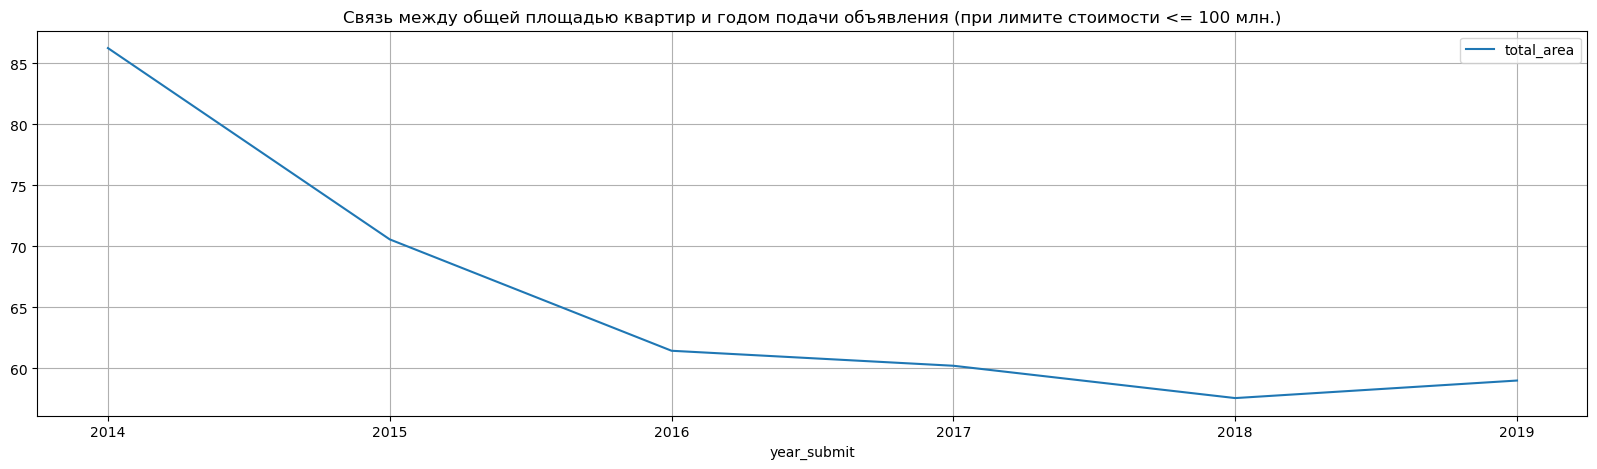

In [110]:
# вызовем query, чтобы сделать срез недвижимости с ценой до 100 млн. Применим к полученному срезу pivot_table для группировки 
# интересующих нас значений. К pivot_table применим функцию plot для построения графика. Для большей нагрядности укажем, что 
# нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('last_price <= 100000000')
    .pivot_table(index='year_submit', values='total_area')
    .plot(grid=True, figsize=(20, 5), 
          title='Связь между общей площадью квартир и годом подачи объявления (при лимите стоимости <= 100 млн.)')
)
plt.show()

Видим, что графики примерно совпадают, а это значит, что в 2014 году было больше объявлений с квартирами, у которых была более крупная общая площадь, что не могло не сказаться на цене. В 2015, 2016 и далее площадь подаваемых квартир падала, что сказалось и на цене.

### 5.9 Вычислим среднюю цену 1 кв.м. в 10 населённых пунктах с наибольшим числом объявлений:

In [111]:
# Создадим сводную таблицу one_sqmetr_cost, в которую при помощи pivot_table поместим значения с подсчетом объявлений по всем
# населенным пунктам и их среднюю цену:
one_sqmetr_cost = data.pivot_table(index='locality_name', values='one_sq_m_price', aggfunc=['count', 'mean'])
# В сводной таблице one_sqmetr_cost создадим новые колонки под полученные значения:
one_sqmetr_cost.columns = ['count', 'mean_price']
# Присвоим значениям в таблице целочисленный тип, для лучшего восприятия. отсортируем значения по убыванию при помощи 
# sort_values с параметром ascending=False. Выведем первые 10 населенных пунктов и сбросим индекс для более корректного 
# отображеия таблицы:
one_sqmetr_cost = one_sqmetr_cost.astype('int').sort_values(by=['count'], ascending=False).head(10).reset_index()
print(one_sqmetr_cost)

       locality_name  count  mean_price
0    Санкт-Петербург  15651      114868
1             Мурино    586       86040
2            Кудрово    470       95260
3     посёлок Шушары    439       78550
4         Всеволожск    398       68654
5             Пушкин    369      103125
6            Колпино    338       75424
7  посёлок Парголово    327       90175
8            Гатчина    307       68745
9             Выборг    237       58141


Видим, что наибольшее количество объявлений о продаже квартиры было подано в Санкт-Петербурге (15651). Самая дорогая недвижимость тоже здесь - в среднем за кв. м. в Санкт-Петербурге просят 114 868 рублей.

Не учитывая Петербург, больше всего объявлений подано в Мурино. Но цена в нём значительно ниже, чем в СПб - за 1 кв.м. предлагают заплатить 86 040 рублей.

Самый недорогой город в сводной таблице выше - Выборг. Здесь 1 кв. м. в среднем стоит 58 141 рублей. 

### 5.10 Посмотрим, как стоимость объектов зависит от расстояния до центра города

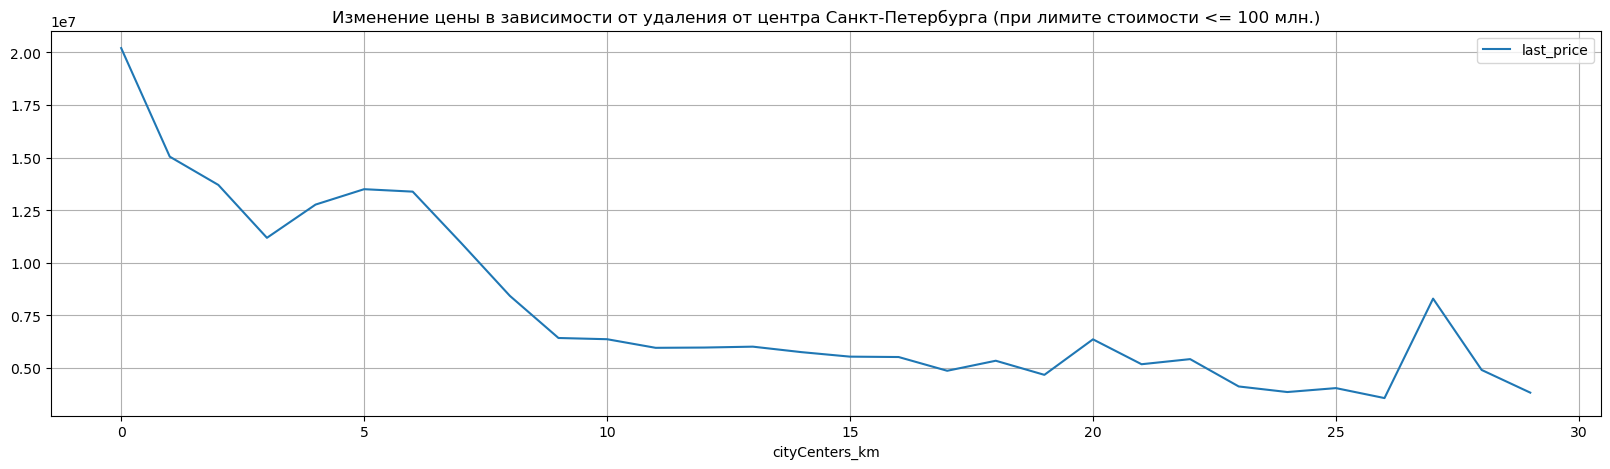

In [112]:
# Сначала построим график изменения цены в зависимости от удаления от центра Санкт-Петербурга. Для этого сделаем срез только тех
# значений, где в качестве населенного пункта (locality_name) указан СПб, установим лимит цены и чтобы исключить влияние 
# значений 999999 в cityCenters_km, которые мы сами установили для пустых значений, поставим требование, что cityCenters_km 
# не может равняться 999999. Применим к полученному срезу pivot_table для группировки интересующих нас значений. К pivot_table 
# применим функцию plot для построения графика. Для большей нагрядности укажем, что нам нужна сетка (grid) и размер (figsize):
(
    data.query('locality_name == "Санкт-Петербург" and last_price <= 100000000 and cityCenters_km != 999999')
    .pivot_table(index='cityCenters_km', values='last_price', aggfunc='mean')
    .plot(grid=True, figsize=(20, 5), 
          title='Изменение цены в зависимости от удаления от центра Санкт-Петербурга (при лимите стоимости <= 100 млн.)')
)
plt.show()

Видим, что центр города - это примерно первые 6 км от центра. Дальше стоимость жилья начинает сильно падать относительно местоположения. Отдельные всплески стоимости есть и на довольно далеких локациях - в 20, 27-28 км от города. Это можно объяснить тем, что в черте СПб могут встречаться ЖК премиум класса, располагающиеся в местах с хорошей инфраструктурой или вблизи от исторических памятников, которые могут позитивно влиять на стоимость.

Ввёдем в датафрейм новую колонку со значениями цены за километр (**price_for_km**), а затем при помощи срезов и сводных таблиц создадим график, отражающий как стоимость объектов зависит от расстояния до центра города.

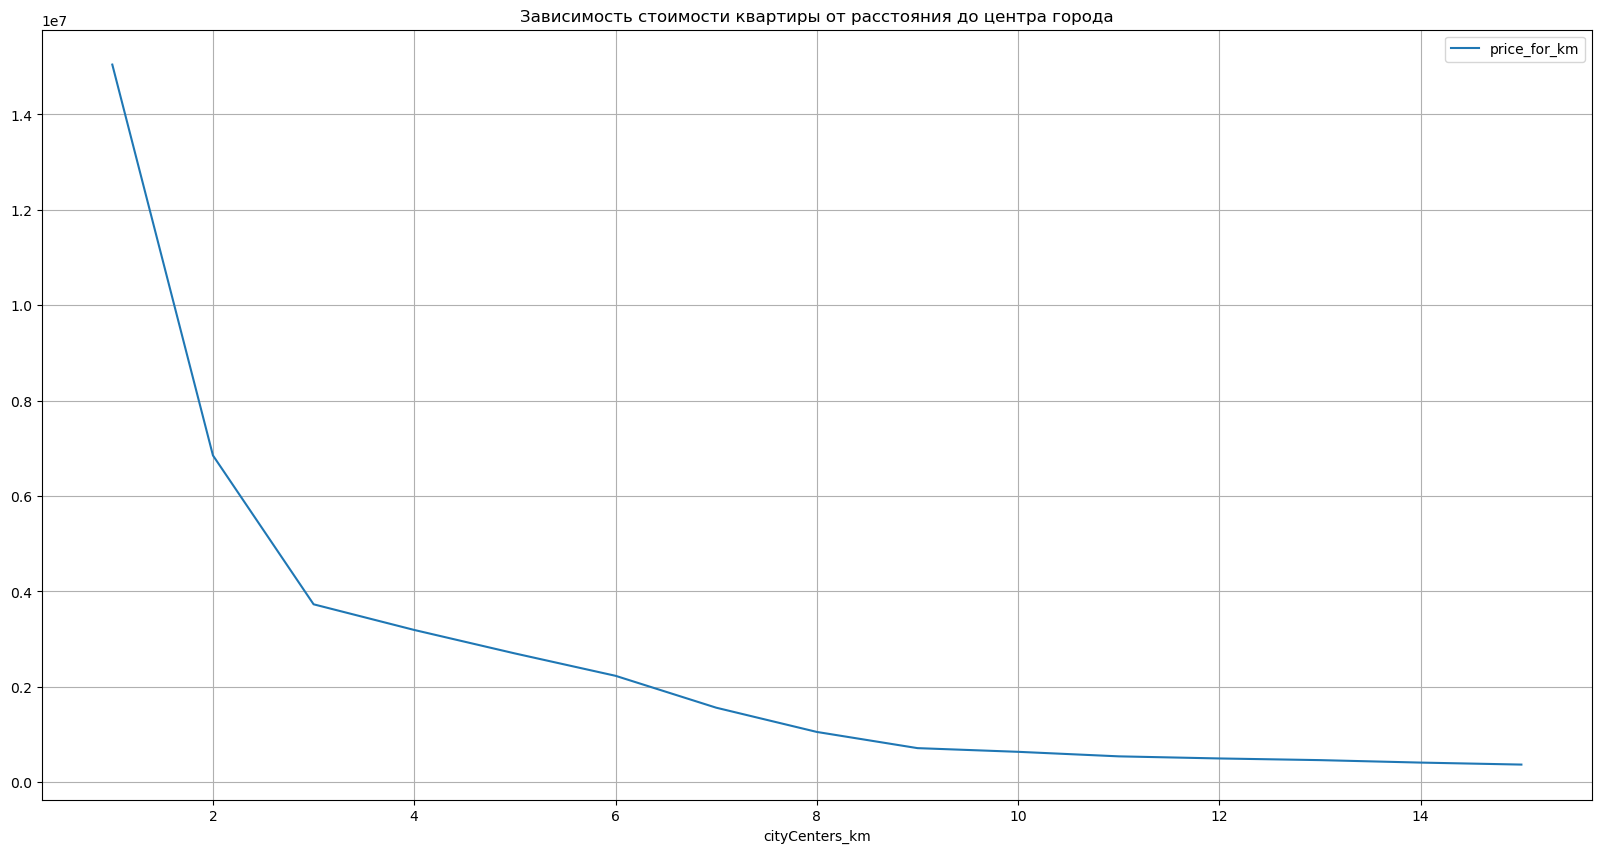

In [113]:
# создаём новую колонку с ценами за км.:
data['price_for_km'] = (data['last_price'] / data['cityCenters_km'])

# сделаем срез только тех значений, где в качестве населенного пункта (locality_name) указан СПб, установим лимит цены и чтобы 
# исключить влияние значений 999999 в cityCenters_km, которые мы сами установили для пропущенных значений, поставим требование, 
# что cityCenters_km не может равняться 999999. Также, установим предел расстояния для анализа - не больше или равно 15 км от 
# центра, чтобы охватить нужные нам данные и посмотреть влияение на смежные значения. Применим к полученному срезу pivot_table 
# для группировки и подсчета интересующих нас значений. К pivot_table применим функцию plot для построения графика. Для большей 
# наглядности укажем, что нам нужна сетка (grid) и предпочитаемый размер (figsize):
(
    data.query('locality_name == "Санкт-Петербург" and cityCenters_km <= 15 and cityCenters_km != 999999 and last_price <= 100000000')
    .pivot_table(index='cityCenters_km', values='price_for_km', aggfunc='mean')
    .plot(grid=True, figsize=(20, 10), title = 'Зависимость стоимости квартиры от расстояния до центра города')
)
plt.show()

Видим, что фактор центра города действительно отражается на цене и сильно. Особое значение он приобретает для недвижимости, находящейся в радиусе 1 км от центра - близость к центру добавляет ей стоимости в десятки миллионов. А вот расстояние уже в 2 км от центра не настолько хорошо влияет на цену. И всё же такая недвижимость будет почти вдвое дороже, чем недвижимость в 3 и, тем более, 4 км от центра. 

Фактор расстояния до центра устойчиво действует до 8 км. С 9 км влияние расстояния до центра всё слабее и слабее.

### Итоговый вывод:

#### Перед исследованием датафрейм прошёл предобработку данных. 

В ходе его изучения было обнаружено значительное количество пропусков. Выяснилось, что отсутствует значительное количество данных в следующих столбцах:
- **ceiling_height (высота потолков)** - часть данных в столбце - аномальные двузначные значения, как 25 м и 32 м, вероятно, были записаны с ошибкой (между цифрами должна быть запятая). Они были обработаны при помощи деления на 10. Те значения, что не поддавались разумной логике (1.4, к примеру, или 8) были приведены к единым разумным значениям для потолков (2.3 если высота меньше этого значения и 4,5 метра, если высота больше этого значения). После корректировки данных была вычислена медиана значений потолков с опорой на общую площадь квартиры (total_area). Ею и были заполнены пропущенные значения столбца ceiling_height. Количество пропусков сократилось с более чем 9000 до 627. Изначально большое количество пропусков здесь, вероятно, можно объяснить тем, что данный столбец многие не считают важным и не заполняют.

- **floors_total (общее число этажей в доме)** - столбец не подвергался обработке, так как количество пропусков незначительно (86 значений из 23699). Мог быть не указан потому, что не посчитали нужным заполнить. Либо же был всего 1 этаж - 1-этажные дома есть в датафрейме.

- **living_area (жилая площадь)** - вероятно, не был заполнен потому, что люди склонны указывать общую площадь и игнорировать заполнение уточняющих значений. Заполнен, где это было возможно, медианными значениями жилой площади, вычисленными с опорой на общую площадь квартиры (total_area).

- **kitchen_area (площадь кухни)** - как и в случае с жилой площадью, вероятно, был проигнорирован из-за того, что ранее человек заполнил общую площадь, а уточняющие данные не посчитал нужным вносить. Заполнен, где это было возможно, медианными значениями площади кухни, вычисленными с опорой на общую площадь квартиры (total_area).

- **is_apartment (данные апартаменты это или нет)** - на местах пропусков проставлен False, поскольку апартаменты довольно редкое жильё в наших краях.

- **balcony (наличие балконов)** - заполнены нулями, поскольку раз человек их не указывал, то, скорее всего, балконов в квартирах и нет.

- **locality_name (локация)** - не обрабатывался, так как пропущенных значений мало (49). При этом представить пропускам логичную альтернативу здесь трудно.

- **days_exposition (сколько дней было размещено объявление (от публикации до снятия))** - данные могли потерятся из-за сбоя - такое значение должно автоматически записываться при снятии объявления за неактуальностью. Заполнены медианными значениями предложений примерно одинакового ценового дипазона.

**Картографические данные:**

- **airports_nearest** (расстояние до ближайшего аэропорта) - 5542 пропуска
- **cityCenters_nearest** (растояние до центра города в метрах) - 5519 пропусков
- **parks_around3000** (парки на расстоянии до 3000 м) - 5518 пропусков
- **ponds_around3000** (пруды на расстоянии до 3000 м) - 5518 пропусков

Обращает на себя внимание тот факт, что количество отсутствующих значений очень похоже. Такая синхронность, скорее всего, говорит о сбоях записи данных. Так как здесь нельзя представить логическую альтернативу пропускам, значения лучше оставить нетронутыми, за исключением столбца cityCenters_nearest заполненного нереалистичными "999999", чтобы с его помощью можно было проводить вычисления.

- **parks_nearest** (ближайшие парки) - 15620 пропусков
- **ponds_nearest** (ближайшие пруды) - 14589 пропусков

Потери тоже схожи, пусть и не так сильно, как в первом случае. Их причиной тоже могут быть сбои в записях данных.

***После работы с пропусками была также проведена работа по изменению типа данных, где это было целесообразно:***
- Столбец **first_day_exposition** был преобразован с типа object на тип datetime, чтобы с ним можно было проводить расчёты;
- Заменены данные в столбце **floors_total** на целочисленный. Вещественный тип данных для него некорректен, так как вряд ли существует этаж, для записи которого требуются дроби. То же самое можно сказать и про столбец **balcony** - вряд ли существует 1,5 балкона или 2,8;
- Столбец **last_price** также приведен к целочисленным значениям для облегчения расчетов.

***В столбце locality_name была проведена работа по устранению неявных дубликатов:***

- Устранено разное написание слова "посёлок": все посЕлки были превращены посЁлки;
- Топоним "городской посёлок" был заменён на тождественный ему аналог "посёлок городского типа";
- Устранены дубли у Рябово, Мурино и Кудрово.

***Перед началом расчётов в датафрейм были помещены новые столбцы:***
- **one_sq_m_price** - стоимость 1 кв.м. недвижимости;
- Столбцы **week_day**, **month_submit** и **year_submit** добавлены, чтобы соответственно отражать день, месяц и год публикации объявления;
- Добавлен столбец **floor_type**, в котором этажи поделены на типы: "Последний", "Первый", "Другой";
- Добавлен столбец **cityCenters_km**, отражающий расстояние до центра в км.

#### Выводы, сделанные в ходе исследования:

- Большая часть недвижимости, представленной в датафрейме, имеет **общую площадь от 30 до 80 кв.м.** Это объяснимо - именно таковы параметры среднестатистических квартир 1-3-комнатности.

- При этом **жилая площадь** большей части квартир в основном колеблется в промежутке **18-50 кв.м.** Тоже подходит под среднестатистическое жилье 1-3-комнатности.

- Большая часть **кухонь** в датафрейме имеет площадь от **5 до 15 кв. м.** Большинство кухонь в реальности примерно такие параметры и имеют.

- Большая часть квартир **оценивается в диапазоне от 2,5 до 7,5 миллионов**. При этом есть экстремально низкие значения (12тыс. за квартиру) и экстремально высокие - стоимость больше 700 млн. Это выбросы, которые нужно учитывать, так как они могут влиять на оценку средней стоимости жилья.

- **Больше всего квартир имеет 1-3 комнаты**. Есть весомые значения и с 4 комнатами, но всё, что больше - встречается довольно редко. Есть странный выброс с 0 комнат, но так могут позиционировать себя студии, где в качестве комнаты выступает кухня-гостинная.

- В подавляющем большинстве квартир встречается **потолок от 2.4 - 2.9 метров**. Есть весомые значения и в области 3 метров - объяснимо тем, что в СПб много квартир старого фонда с подобными потолками.

- Абсолютное большинство квартир из базы располагаются **на этаже от 1 до 10**. При этом наибольшее количество объектов в сегменте этажности **от 1 до 5**.

- В датафрейме больше всего квартир, которые расположены на **"другом" этаже** - не на первом и не на последнем. Первый и последний этажи представлены примерно поровну.

- В гистограмме, отражающей распределение этажности домов, много пиков - это не типичное распределение. Но конкретно для этажей подобное скорее нормально - в Санкт-Петербурге и Ленобласти много домов "старого фонда" с низкой этажностью (2-4 этажа) и "панелек" с типовой этажностью 5-9-12 этажей. В последние годы растет и количество высокоэтажных новостроек с разной этажностью. Учитывая, что большая часть пиков принадлежит **5-ти и 9-ти этажкам (именно в таких домах располагается большая часть квартир из датафрейма)**, гистограмма похожа на правду.

- Наибольшая часть квартир в датафрейме находится на расстоянии **10000-18000 метров от центра**. Это соответствует подавляющему большинству локаций черте СПб. При этом солидная часть квартир находится как достаточно близко к историческому центру СПб (3000-6000 м.), так и довольно далеко (28000-34000 м.) - это уже скорее локации из Ленобласти.

- Большая часть квартир находится на расстоянии примерно **100 и до 700 м. до ближайшего парка**. Мало кто живёт в квартире, которая располагается более чем в 1000 м. от парка. Объекты недвижимости, находящиеся на расстоянии от парка вплоть более чем в 2500 м. - большая редкость.

- Большая часть квартир находится на расстоянии **от 7000 до 40000 м. от аэропорта**. Это в целом похоже на правду - квартиры в разных районах могут быть как ближе к аэропорту, так и дальше. 

- Большая часть объявлений пользователи опубликовывали на буднях. При этом самые активные для публикаций дни: **вторник(1) и четверг(3)**. Примерно в 2 раза меньше публикуется объявлений на выходных.

- Чаще всего объявления о продаже квартиры публикуются **с февраля по апрель и с сентября по ноябрь**. В периоды с мая по август и в декабрь-январь объявлений публикуется на порядок меньше.

- Большая часть квартир продаётся в течение первых 200 дней. При этом быстрой можно считать продажу, если она состоялась в первые 45 дней от публикации объявления. А необычно долгой, если квартира продаётся 215 дней и более.

#### Были построены графики взаимосвязи цены и различных параметров.

Для построения графиков зависимости цены от различных факторов при помощи срезов были отброшены данные, где цена превышала 100 млн. Такие цены мало похожи на правду, даже в достаточно дорогом по недвижимости СПб, и могут сильно искажать выводы.

Графики делались при помощи диаграмм рассеяния, сводных таблиц с нужными значениями и функции plot. По ним удалось установить, что:

1. **Есть достаточно сильная взаимосвязь цены и общей площади квартиры**. Корреляция Пирсона эту связь подтверждает значением в 0.65. Можно сделать вывод, что чем больше площадь, тем дороже квартира. Но учитывая, что значение зависимости не самое большое, нужно не упускать из виду то, что площадь - явно не единственный фактор, который влияет на стоимость квартиры.

2. **Есть умеренная связь цены и жилой площади**. Корреляция Пирсона здесь - 0.57: чем больше жилая площадь, тем дороже квартира. Но связь меньше, чем в случае с общей площадью.

3. **Есть умеренная связь цены и площади кухни**. Корреляция Пирсона здесь - 0.49. Большая площадь кухни увеличивает стоимость квартиры, но её влияние на порядок ниже, чем у общей площади.

4. **Количество комнат если и влияет на цену, то слабо** - корреляция Пирсона здесь всего 0.36. По графику видим, что количество комнат оказывает явное влияние пока их количество не превысит 6. После влияние на цену смазывается, за исключением случайного выброса в 15 комнат.

5. **Дороже всего стоят квартиры, расположенные на "Другом" и "Последнем" этажах**. Самые дешевые квартиры с первого этажа. Это объяснимо - у первого этажа много недостатков, снижающих цену: высокая проходимость и шум из-за этого, низко расположенные окна, в которые могут заглядывать посторонние.

6. **Самые дорогие цены на квартиры люди склонны устанавливать, подавая объявление в четверг**. При этом меньше всего стоят квартиры, которые подают в сб и вс.

7. В графике связи между месяцем подачи объявления и ценой интересно то, что октябрь - один из месяцев, в который люди подают больше всего объявлений, показывает антирекорд по ценовому сегменту - именно **в октябре размещаются самые недорогие предложения**. Примерно то же самое можно сказать и про март.

Также, в графике с апреля по ноябрь можно наблюдать примерно одинаковые пики то снижения цены недвижимости, то её увеличения. Это может быть связано с тем, что дорогие квартиры продаются тяжело и долго, вследствие чего объявления с ними переподаются заново в сервис через 45-60 дней.

8. Судя по графику взаимосвязи между годом подачи объявления и ценой, **пик самых дорогих объявлений пришёлся на 2014 год**. Это объясняется тем, что тогда же был пик подачи объявлений с наибольшей общей площадью квартиры. Далее площадь подаваемых квартиры их года в год падала, что и сказалось на цене.

##### Были проведены вычисления с целью обнаружить среднюю цену 1 кв.м. в 10 населённых пунктах с наибольшим числом объявлений.

По результатам этих вычислений можно сделать выводы, что **чаще всего продаются квартиры в Санкт-Петербурге**: 15651 объявлений со средней ценой за кв.м. в 114 868.

**На втором месте** по количеству объявлений - **Мурино** (586 шт.) При этом цена за кв. м. значительно ниже петербуржской - 86040.

Зато **город Пушкин** хоть и находится на 6 месте по количеству объявлений в датафрейме (369 шт.), **второй по дороговизне город**, после СПб - 103125 в среднем стоит 1 кв.м. квартиры в нём.

**Самый недорогой** из 10-ки городов с наибольшим количеством объявлений - **Выборг**. В нём 1 кв.м. обойдется почти в 2 раза дешевле, чем в Санкт-Петербурге - 58141.

##### Был построен график зависимости цены от расстояния до центра СПб.

Для этой цели сначала было выделено определённое расстояние, которое можно было приравнять к центру и явно влияющее этим параметром на цену. А затем на его базе и близлежащих значениях был сделан график, наглядно показывающий, как близость к центру может влиять на расстояние.

По этому графику можно сделать вывод, что наибольший вклад в цену вносит расположение квартиры в пределах от 0 до 2 км. от центра города. Такая близость может добавить квартире десятки миллионов к стоимости - **чем ближе к 0 км от центра, тем дороже**.

Расположение на расстоянии 2-3 км. Тоже влияет на цену, но на порядок ниже. Тем не менее, квартиры здесь могут быть почти вдвое дороже, чем недвижимость в 3 и, тем более, 4 км от центра. 

**Расстояние до центра устойчиво повышает цену квартиры до 8 км. С 9 км влияние расстояния до центра ощутимо слабо.**

#### Цель исследования достигнута:

Выводы позволят выделить наиболее важные параметры данных, которые сильнее всего влияют на стоимость недвижимости. Это позволит создать систему отслеживания объявлений, которая будет улавлить появление аномалий и артефактов в данных, как случайных, так и внесённых предумышленно с целью исказить статистику.